# Explainer notebook - Football Chemistry


### Social graph and interactions - 02805

This notebook only explains how we created our plots, networks, sentiment analysis and cleaned our datasets so they could be utilised the best. To see how we got the data go see the link below the libraries. 

*Before going on, we want to mention that we changed our project from youtuber analysis to this fifa world cup analysis. This was done due to the feedback requesting a bigger network and also because our interest was not really there.*

*Notice* the files you need to run this code are the **teams.csv**, **players.csv** and **Fifa_Cleaned.csv** the files can be found in the github profile. If you dont want to run and download all the wiki links, aritcle links and fifa links you can simply just download the *archive.ZIP* from https://github.com/Milo4220god/SocialGraph2022. It is important that you extract the files to the same folder as you run this code due to us using os.listdir. You could also of couse just change this function from os.listdir to your path. 

## Import the neeeded libraries 

In [34]:
# The needed libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import re
import warnings
from datetime import datetime, timedelta
from collections import defaultdict
import glob
from fuzzywuzzy import process
from bs4 import BeautifulSoup
import networkx as nx
from networkx.algorithms import bipartite
from community import community_louvain
import requests
import json
import urllib.request
from fa2 import ForceAtlas2
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.book import *
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from collections import Counter
import requests
import warnings
from datetime import datetime, timedelta
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer


Link to other notebook. This is some of the functions we created to get data from webpages. Go see 'https://github.com/Milo4220god/SocialGraph2022/blob/main/new_clean_test.ipynb' for a deeper walkthrough of it.

If for some reason you chose not to the link - the below code is a snippet of how we did it. 

In [ ]:
# create funtions to get the data from football-API
def getLeagues():
    '''
    This function returns a pandas dataframe with all leagues and their IDs
    Notice: the league_name is not unique, but the league_id is
    '''
    warnings.filterwarnings("ignore")
    url = 'https://api-football-v1.p.rapidapi.com/v3/leagues'
    headers = {
        "X-RapidAPI-Key": "3a8842c629msh137ccc2c9a9ad3fp15a6dbjsn9bfbbc1cb922",
        "X-RapidAPI-Host": "api-football-v1.p.rapidapi.com"
    }
    response = requests.request("GET", url, headers=headers)

    leagues = response.json()['response']

    df = pd.DataFrame(columns=['league_id', 'league_name'])
    for league in leagues:
        df = df.append({'league_id': league['league']['id'], 'league_name': league['league']['name']}, ignore_index=True)
    
    return df

def getTeams(league_id, year='2022'):
    '''
    This function returns a pandas dataframe with all teams and their IDs
    Input: league_id, (year)
    '''
    warnings.filterwarnings("ignore")
    url = 'https://api-football-v1.p.rapidapi.com/v3/teams'
    params = {'league': str(league_id), 'season': str(year)}
    headers = {
        "X-RapidAPI-Key": "3a8842c629msh137ccc2c9a9ad3fp15a6dbjsn9bfbbc1cb922",
        "X-RapidAPI-Host": "api-football-v1.p.rapidapi.com"
    }
    response = requests.request("GET", url, headers=headers, params=params)
    teams = response.json()['response']

    df = pd.DataFrame(columns=['team_id', 'team_name'])
    for team in teams:
        df = df.append({'team_id': team['team']['id'], 'team_name': team['team']['name']}, ignore_index=True)
    return df

def getteamsforcountry(country):
    '''
    This function returns a pandas dataframe with all teams and their IDs
    Input: league_id, (year)
    '''
    warnings.filterwarnings("ignore")
    url = 'https://api-football-v1.p.rapidapi.com/v3/leagues'
    params = {'country': str(country)}
    headers = {
        "X-RapidAPI-Key": "3a8842c629msh137ccc2c9a9ad3fp15a6dbjsn9bfbbc1cb922",
        "X-RapidAPI-Host": "api-football-v1.p.rapidapi.com"
    }
    response = requests.request("GET", url, headers=headers, params=params)
    teams = response.json()['response']
    # convert teams to pandas dataframe
    df = pd.DataFrame(columns=['league_id', 'team_name'])
    for team in teams:
        df = df.append({'league_id': team['league']['id'], 'team_name': team['league']['name']}, ignore_index=True)
    return df
    



def getMatches(league_id, team_id, year='2022'):
    '''
    This function returns a pandas dataframe with all matches of a team in a league
    Input: league_id, team_id, (year)
    '''
    print("Trying to fetch matches for team_id: " + str(team_id) + " and league_id: " + str(league_id))
    warnings.filterwarnings("ignore")
    url = 'https://api-football-v1.p.rapidapi.com/v3/fixtures'
    params = {'league': str(league_id), 'season': str(year), 'team': str(team_id)}
    headers = {
        "X-RapidAPI-Key": "b488e0c68amsh64a0fa30d4a8df1p16e1a6jsn1f268e40bf08",
        "X-RapidAPI-Host": "api-football-v1.p.rapidapi.com"
    }
    # if response is not 200, print error message
    response = requests.request("GET", url, headers=headers, params=params)
    if response.status_code != 200:
        print("Error: " + response.json()['message'])
        return None
    df = pd.DataFrame(columns=['fixture_id', 'home_team_id', 'away_team_id', 'goals', 'timezone', 'date', 'timestamp', 'first_half', 'second_half'])
    for fixture in response.json()['response']:
        fixture_id = fixture['fixture']['id']
        home_team_id = fixture['teams']['home']['id']
        away_team_id = fixture['teams']['away']['id']
        goals = fixture['goals']
        timezone = fixture['fixture']['timezone']
        date = fixture['fixture']['date']
        timestamp = fixture['fixture']['timestamp']
        periods = fixture['fixture']['periods']
        first_half = periods['first']
        second_half = periods['second']
        df = df.append({'fixture_id': fixture_id, 'home_team_id': home_team_id, 'away_team_id': away_team_id, 'goals': goals, 'timezone': timezone, 'date': date, 'timestamp': timestamp, 'first_half': first_half, 'second_half': second_half}, ignore_index=True)
    
    df['home_team_goals'] = df['goals'].apply(lambda x: x['home'])
    df['away_team_goals'] = df['goals'].apply(lambda x: x['away'])
    df = df.dropna(subset=['home_team_goals', 'away_team_goals'])
    df = df.drop(columns=['goals'])
    
    return df

def getEvents(fixture_id):
    print("Trying to fetch events for fixture_id: " + str(fixture_id))
    warnings.filterwarnings("ignore")
    url = 'https://api-football-v1.p.rapidapi.com/v3/fixtures/events'
    headers = {
        "X-RapidAPI-Key": "b488e0c68amsh64a0fa30d4a8df1p16e1a6jsn1f268e40bf08",
        "X-RapidAPI-Host": "api-football-v1.p.rapidapi.com"
    }
    params = {'fixture': str(fixture_id)}
    response = requests.request("GET", url, headers=headers, params=params)
    if response.status_code != 200:
        print("Error: " + response.json()['message'])
        return None
    
    # convert to pandas dataframe
    df = pd.DataFrame(response.json()['response'])
    
    # manipulate dataframe
    df['elapsed_time'] = df['time'].apply(lambda x: x['elapsed'])
    df = df.drop(columns=['time'])
    df['team_id'] = df['team'].apply(lambda x: x['id'])
    df['team_name'] = df['team'].apply(lambda x: x['name'])
    df['player_id'] = df['player'].apply(lambda x: x['id'])
    df['player_name'] = df['player'].apply(lambda x: x['name'])
    df = df.drop(columns=['team', 'player', 'assist'])
    df = df[df['type'] == 'Goal']

    return df

def get_all_goals_with_timestamps(league_id, team_id, year='2022'):
    warnings.filterwarnings("ignore")
    matches = getMatches(league_id, team_id, year)
    # if no rows in matches, return None
    if matches.shape[0] == 0:
        print("No matches found for team_id: " + str(team_id) + " and league_id: " + str(league_id))
        return None
    allGoals = defaultdict(lambda: '')
    for index, row in matches.iterrows():
        fixture_id = row['fixture_id']
        goals = getEvents(fixture_id)
        # for each goal, check if elapsed time is in first or second half and add to allGoals
        for index, goal in goals.iterrows():
            if goal['elapsed_time'] <= 45:
                stamp = row['first_half'] + goal['elapsed_time']*60
                # variable that is used to check if the goal is scored by the home team or away team
                team = 'away' if goal['team_id'] != team_id else 'home'
                allGoals[stamp] = team
            else:
                stamp = row['second_half'] + goal['elapsed_time']*60
                # variable that is used to check if the goal is scored by the home team or away team
                team = 'away' if goal['team_id'] != team_id else 'home'
                allGoals[stamp] = team
    # convert defaultdict to dict
    return dict(allGoals)

def generate_tickers(eventTime, ticker):
    b = get_binance_data(datetime.utcfromtimestamp(eventTime), start_time=datetime.utcfromtimestamp(eventTime-(60*5)), end_time=datetime.utcfromtimestamp(eventTime+(60*6)), ticker=ticker)
    tickers = generate_timebars(b, frequency='10S')
    return tickers

def save_goal_charts(goals, ticker):
    for k, v in goals.items():
        goal_time = datetime.utcfromtimestamp(k)
        tick = generate_tickers(k, ticker)
        # make time column datetime and set as index
        tick['time'] = pd.to_datetime(tick['time'], unit='ms')
        tick = tick.set_index('time')
        try:
            mpl.plot(
                tick,
                type="candle",
                title = ticker,
                style="yahoo",
                vlines=dict(vlines=[goal_time],linewidths=(2)),
                savefig=dict(fname=f"charts/{ticker}_{goal_time}.png", dpi=300, pad_inches=0.25)
            )
        except:
            print("Error with chart for goal at: " + str(goal_time) + ". Skipping...")
    return True

def get_all_goal_charts(league_id, team_id, ticker, year='2022'):
    goals = get_all_goals_with_timestamps(league_id, team_id, year)
    if goals is None:
        return False
    goals = {k: v for k, v in goals.items() if v == 'home'}
    if len(goals) <= 1:
        return False
    save_goal_charts(goals, ticker)
    return True

In [ ]:
# use funtion to get leagues
League_ids = getLeagues()

# save league ids to csv as we do not have unlimited calls
League_ids.to_csv('League_ids.csv', index=False)

# get all the teame names from the league ids manually due to limited calls 

teams_Ligue_1 = getTeams(61) # Ligue 1

# get the team names for Premier League

teams_Premier_League = getTeams(39) # Premier League

teams_Premier_League.to_csv('teams_Premier_League.csv', index=False)


We did it for all leagues in the file called "All teams manually" and loaded all the files into a dataframe as below

#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "teams_*.csv"))))
\
\
#df.to_csv('teams.csv', index=False)

## Data Cleaning

To see how we created the three datasets, please see the other notebook in the github profile as it was a rather long process and we did not see it fit to add to our explainer/analysis notebook.

In [2]:
df_league = pd.read_csv("teams.csv") # all the leagues and the clubs
df_player = pd.read_csv("players.csv") # all the players and their clubs
df_fifa = pd.read_csv("FIFA23_Cleaned.csv") # all the players and their stats

To create some similarity in each dataset we renamed the columns in the datasets and dropped the columns that we knew we would not use for this project. 

In [3]:
#renmaing columns in league data
df_league = df_league.rename(columns={"team_name": "Club","country":"Leauge_country"})

In [4]:
#renameing and dropping columns in df_player
df_player = df_player.drop(['Unnamed: 0', 'No.', 'Date of birth (age)'], axis=1)# removing unnecessary 
df_player['Club2'] = df_player['Club'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

df_player =pd.DataFrame(df_player)
df_player =df_player.drop(['Club'], axis=1)
df_player = df_player.rename(columns={"Club2": "Club"})
#df_player

In [5]:
df_all = pd.merge(df_league, df_player, how = 'right', on='Club') # merging the two datasets
df_all

team_id              Club Leauge_country Pos.            Player  Caps  \
0     1156.0             Aucas        Equador   GK   Hernán Galíndez    12   
1     2285.0     Santos Laguna         Mexico   DF      Félix Torres    17   
2      168.0  Bayer Leverkusen        Germany   DF    Piero Hincapié    21   
3      126.0         Sao Paulo         Brazil   DF   Robert Arboleda    33   
4     1616.0    Los Angeles FC            USA   MF    José Cifuentes    11   
..       ...               ...            ...  ...               ...   ...   
825    492.0            Napoli          Italy   FW    Hirving Lozano    60   
826   2282.0         Monterrey         Mexico   DF    Jesús Gallardo    78   
827   2292.0           Pachuca         Mexico   MF       Luis Chávez     9   
828      NaN       Guadalajara            NaN   FW  Roberto Alvarado    31   
829   2292.0           Pachuca         Mexico   DF     Kevin Álvarez     8   

     Goals  Country  
0        0  Ecuador  
1        2  Ecuador  
2        1  Ecuador  
3        2  Ecuador  
4        0  Ecuador  
..     ...      ...  
825     16   Mexico  
826      1   Mexico  
827      0   Mexico  
828      4   Mexico  
829      0   Mexico  

[830 rows x 8 columns]

We noticed that many of the club names in the dataset was not similar with the others. One of the dataset did not write the full name of the club while the other dataset did e.g. one called it AC Milan did other dataset named it just Milan. This was a problem as it created a lot of nan values as players suddenly had no club.  

In [6]:
# finding the simalarities in the rows, based on the words that are similar. 
df_player['Club'] = df_player.apply(lambda x: process.extractOne(x['Club'], df_league['Club'])[0] if x['Club'] else None, axis=1)


In [7]:
#merging them together one more time. 
df1=pd.merge(df_player,df_league,on='Club')
df1[df1['Player']=='Simon Kjær (captain)'] # test

Pos.                Player  Caps  Goals  Country      Club  team_id  \
303   DF  Simon Kjær (captain)   121      5  Denmark  AC Milan      489   

    Leauge_country  
303          Italy

We noticed that the player in 797 was assigned to the wrong leauge name suddenly. 

In [8]:
df1.at[797,'Leauge_country']='UAE' 

Another thing we realised was that their is supposed to be 830 players participating in the worldcup, so how come we had 831 rows.

In [9]:
df1[df1['Player'].duplicated(keep=False)] # There are two Cho Yu-min for some reason. So we will drop one.

Pos.      Player  Caps  Goals      Country             Club  team_id  \
771   DF  Cho Yu-min     4      0  South Korea  Daejeon Citizen     2750   
772   DF  Cho Yu-min     4      0  South Korea  Daejeon Citizen     2750   

    Leauge_country  
771    South Korea  
772    South Korea

In [10]:
df1= df1.drop_duplicates().reset_index() # removing Cho 

# create copy of df1
df3 = df1.copy()

To make it easier for us we also decided to remove the captain in the name of the captain players and the danish letters ø,æ and å. Moreover, we added the column Wikilink so that we ready to extract articles later. 

In [11]:
df1['Player'] = df1['Player'].str.replace(' \(captain\)', '') # removing captain
df1['Player'] = df1['Player'].str.replace('æ', 'ae') # replaing the letters 
df1['Player'] = df1['Player'].str.replace('ø', 'oe')
df1['Player'] = df1['Player'].str.replace('å', 'aa')
df1['WikiLink'] = df1['Player'].str.replace(' ', '_')
df1

C:\Users\Bruger\AppData\Local\Temp\ipykernel_16576\1853758072.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['Player'] = df1['Player'].str.replace(' \(captain\)', '') # removing captain


index Pos.            Player  Caps  Goals      Country  \
0        0   GK   Hernán Galíndez    12      0      Ecuador   
1        1   DF      Félix Torres    17      2      Ecuador   
2        2   MF   Ayrton Preciado    27      3      Ecuador   
3        3   DF    Piero Hincapié    21      1      Ecuador   
4        4   DF  Jeremie Frimpong     0      0  Netherlands   
..     ...  ...               ...   ...    ...          ...   
825    826   DF    Jesús Gallardo    78      1       Mexico   
826    827   DF     Johan Vásquez     7      0       Mexico   
827    828   FW       Alexis Vega    22      6       Mexico   
828    829   FW  Roberto Alvarado    31      4       Mexico   
829    830   MF    Héctor Herrera   102     10       Mexico   

                   Club  team_id Leauge_country          WikiLink  
0                 Aucas     1156        Equador   Hernán_Galíndez  
1         Santos Laguna     2285         Mexico      Félix_Torres  
2         Santos Laguna     2285         Mexico   Ayrton_Preciado  
3      Bayer Leverkusen      168        Germany    Piero_Hincapié  
4      Bayer Leverkusen      168        Germany  Jeremie_Frimpong  
..                  ...      ...            ...               ...  
825           Monterrey     2282         Mexico    Jesús_Gallardo  
826           Cremonese      520          Italy     Johan_Vásquez  
827  Guadalajara Chivas     2278         Mexico       Alexis_Vega  
828  Guadalajara Chivas     2278         Mexico  Roberto_Alvarado  
829      Houston Dynamo     1600            USA    Héctor_Herrera  

[830 rows x 10 columns]

## Preliminary assumptions.  

Since we had the data, we wanted to see who had played the most together and what team that would be the most "dangerous" based on goals scored 

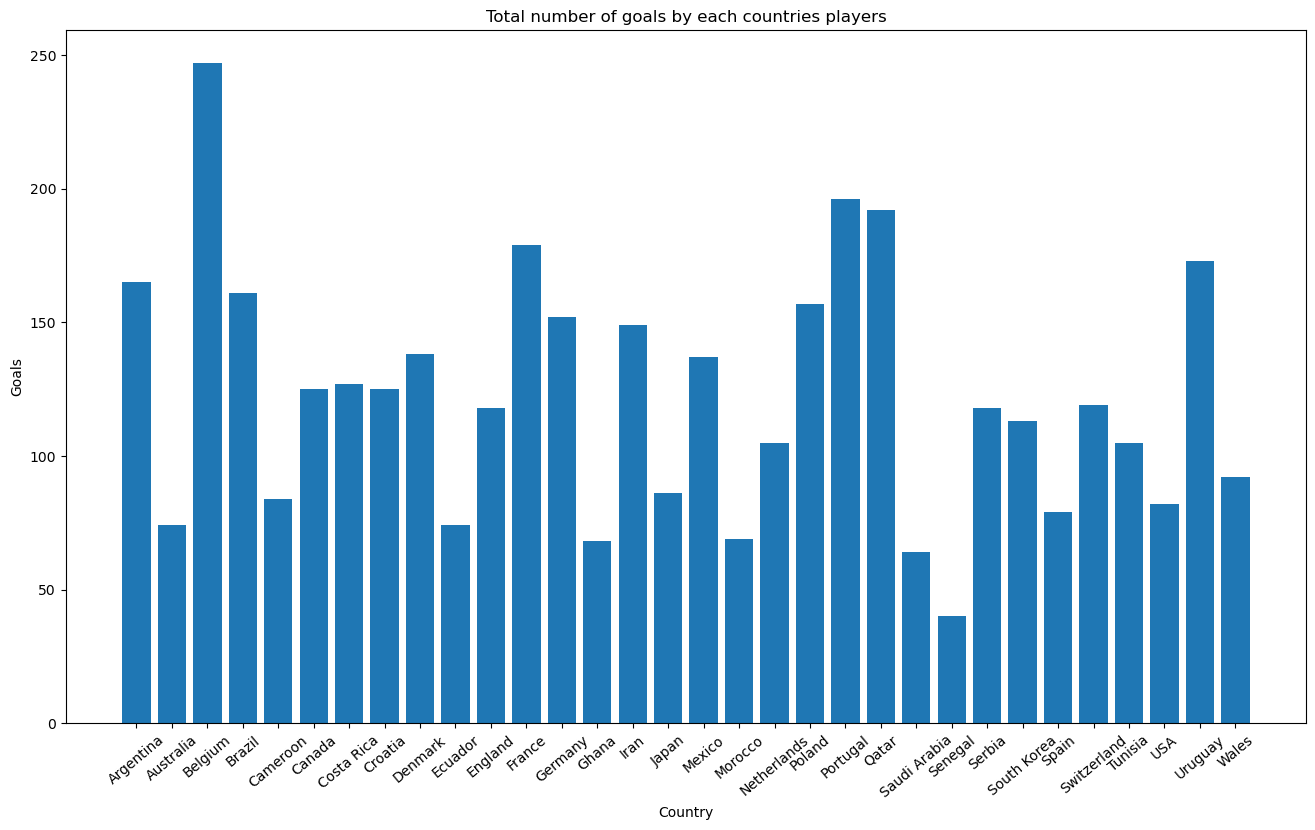

In [12]:
goals_by_country = df1.groupby('Country')['Goals'].sum()


plt.figure(figsize=(16,9))
plt.bar(goals_by_country.index,goals_by_country.values) # plotting values 
plt.title("Total number of goals by each countries players")
plt.xticks(rotation=40)
plt.xlabel("Country")
plt.ylabel("Goals")


plt.show()

In [ ]:
# add the overall column to the dataset

df3['Overall'] = df3['Player'].map(df_fifa.set_index('Player')['Overall'])

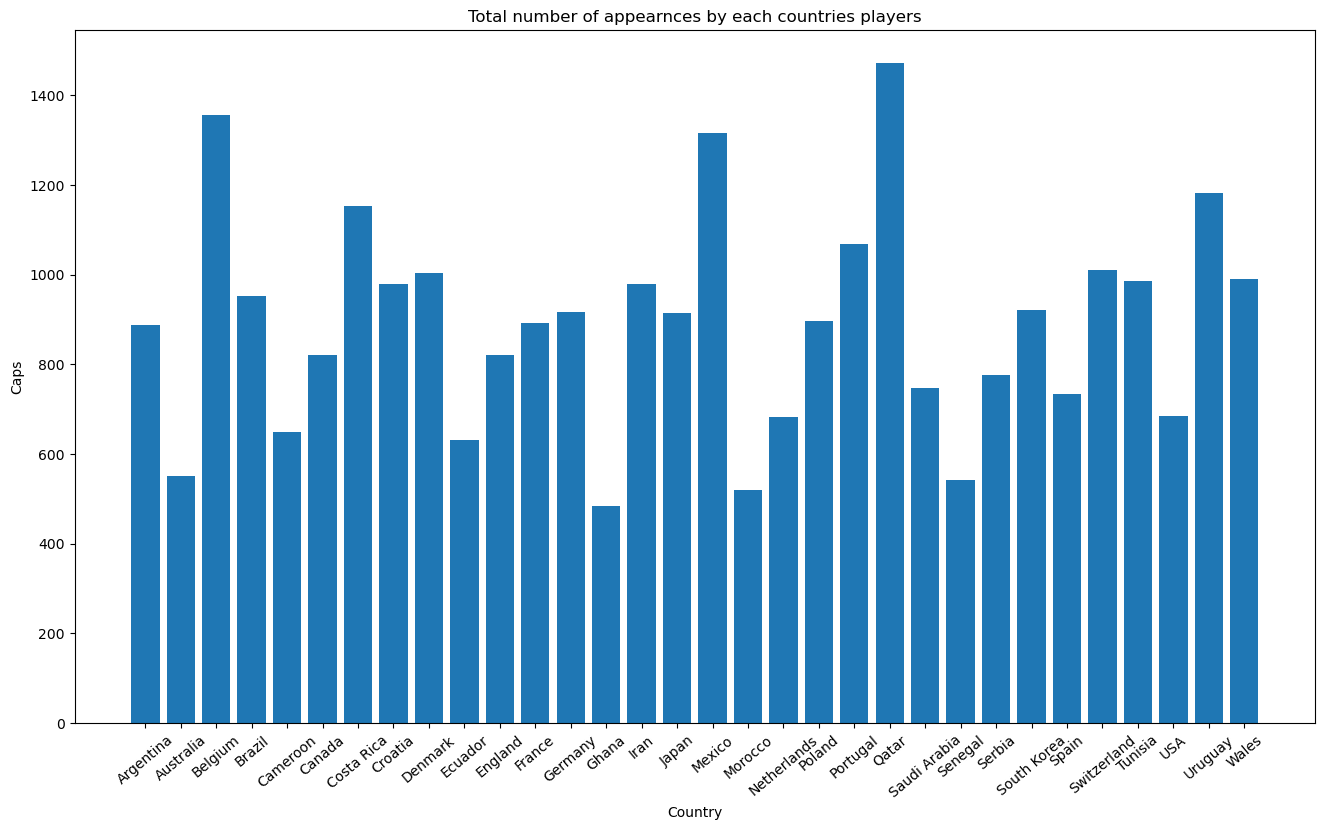

In [13]:
caps_by_country = df1.groupby('Country')['Caps'].sum()

plt.figure(figsize=(16,9))
plt.bar(caps_by_country.index,caps_by_country.values)
plt.title("Total number of appearnces by each countries players")
plt.xticks(rotation=40)
plt.xlabel("Country")
plt.ylabel("Caps")

plt.show()

This shows that Belgium seems to be a team that knows each other well and can score a lot of goals.

In [ ]:
# remove columns Pos., index, team_id, Leauge_country, WikiLink

df3 = df3.drop(['Pos.', 'index', 'team_id', 'Leauge_country'], axis=1)

df3['Player'] = df3['Player'].str.replace(' \(captain\)', '')
df3['Player'] = df3['Player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df3


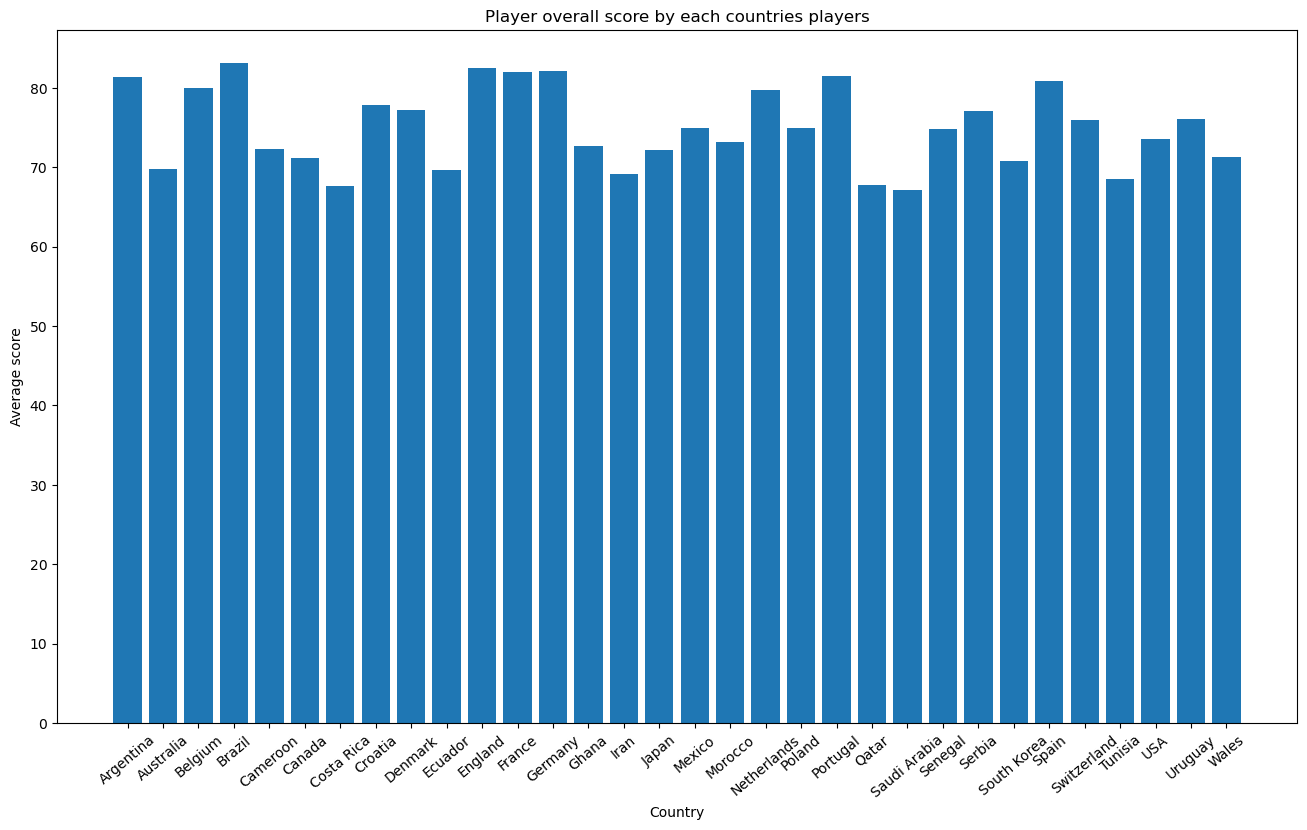

In [183]:
Performance_by_country = df3.groupby('Country')['Overall'].mean()


plt.figure(figsize=(16,9))
plt.bar(Performance_by_country.index,Performance_by_country.values)
plt.title("Player overall score by each countries players")
plt.xticks(rotation=40)
plt.xlabel("Country")
plt.ylabel("Average score")



plt.show()

By looking at the graph we can see the average score of each team. it seems that Brazil have the team if the best overall player score. But there are other strong contenderes right behind them.

In [174]:
df3.groupby('Country')['Overall'].mean() # a closer look at the exact numbers behind the graph

Country
Argentina       81.307692
Australia       69.769231
Belgium         79.923077
Brazil          83.115385
Cameroon        72.346154
Canada          71.192308
Costa Rica      67.576923
Croatia         77.884615
Denmark         77.192308
Ecuador         69.692308
England         82.538462
France          82.038462
Germany         82.115385
Ghana           72.692308
Iran            69.120000
Japan           72.153846
Mexico          75.000000
Morocco         73.230769
Netherlands     79.730769
Poland          74.884615
Portugal        81.461538
Qatar           67.730769
Saudi Arabia    67.115385
Senegal         74.800000
Serbia          77.038462
South Korea     70.807692
Spain           80.807692
Switzerland     76.000000
Tunisia         68.576923
USA             73.500000
Uruguay         76.076923
Wales           71.346154
Name: Overall, dtype: float64

Brazil, England, France and Germany seems to have the best overall indivdual players. 

## Network part

Now for the network part. We wanted to see how many people are representing the same club and what country that player belongs to. 

In [14]:
G = nx.from_pandas_edgelist(df1, source = 'Club', target = 'Country', create_using=nx.MultiDiGraph)

In [15]:
print(nx.info(G))

MultiDiGraph with 322 nodes and 830 edges


C:\Users\Bruger\AppData\Local\Temp\ipykernel_16576\2606185536.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [16]:
club = df1['Club']

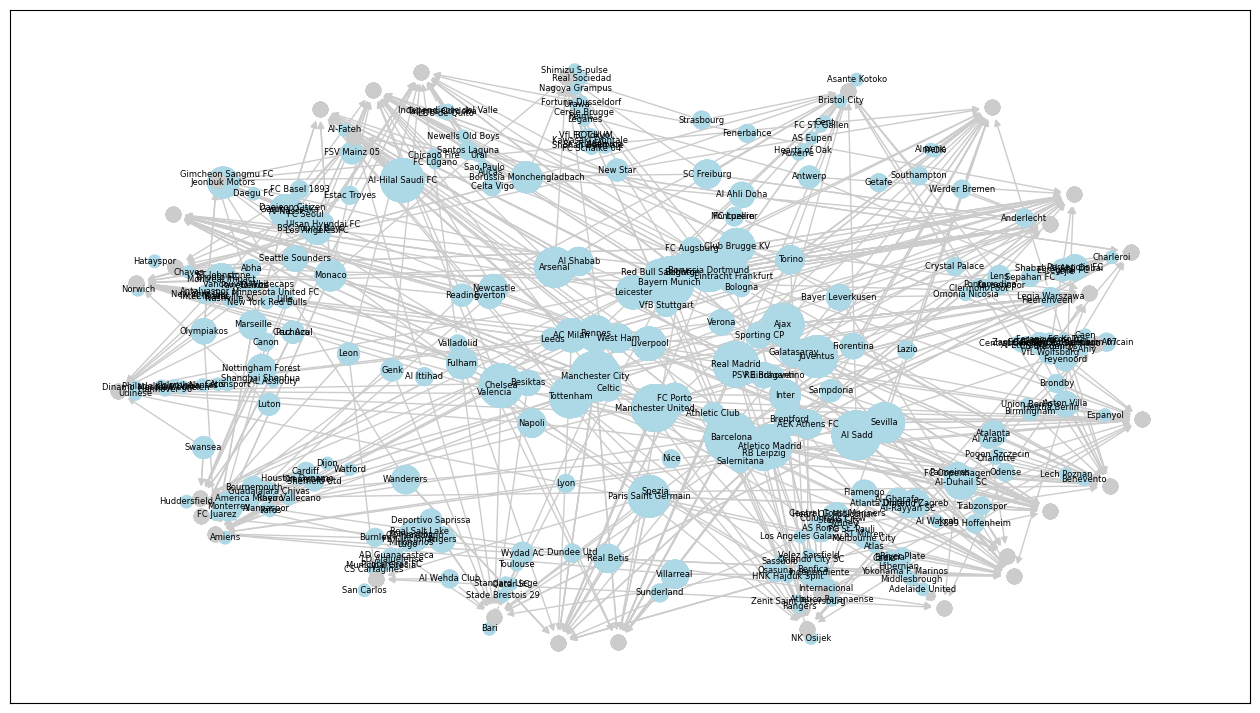

In [17]:
layout = nx.spring_layout(G,iterations=50)


plt.figure(figsize = (16,9))

club_size = [G.degree(club) * 80 for club in club] # size
nx.draw_networkx_nodes(G, 
                       layout, 
                       nodelist=club, 
                       node_size=club_size, 
                       node_color='lightblue')

# Draw 
nx.draw_networkx_nodes(G, layout, nodelist=df1['Country'], node_color='#cccccc', node_size=100)

nx.draw_networkx_edges(G, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(club, club)) # labes of the clubs
nx.draw_networkx_labels(G, layout, labels=node_labels, font_size=6 )

plt.show()

Here it is clear to see that some of the biggest clubs in the world are also them with the most representatives, which is why they are centralised e.g. bayern munich and real madrid are all in the center. However, what is even more interesting is that the node Al Hilal is just as large as the aforementioned nodes, however, it is much closer to the Saudi arabia node(the grey one). This means that Al hilal have a lot of players with the same nationality. 

In [18]:
in_degree = G.in_degree()
sorted_in_degree = sorted(in_degree, key=lambda x: x[1], reverse=True)
print(sorted_in_degree[:10])

[('Ecuador', 26), ('Netherlands', 26), ('Argentina', 26), ('USA', 26), ('Wales', 26), ('Belgium', 26), ('Japan', 26), ('Spain', 26), ('Ghana', 26), ('Poland', 26)]


No suprise here, since every team is allowed to have 26 players in the team.

In [19]:
out_degree = G.out_degree()
sorted_out_degree = sorted(out_degree, key=lambda x: x[1], reverse=True)
print(sorted_out_degree[:10])

[('Barcelona', 17), ('Bayern Munich', 16), ('Manchester City', 16), ('Al Sadd', 15), ('Manchester United', 14), ('Real Madrid', 13), ('Al-Hilal Saudi FC', 12), ('Atletico Madrid', 12), ('Chelsea', 12), ('Ajax', 11)]


As we could see in the network above, Al-Hilal is represented by 12 players. 

In [20]:
# Some basic stats
print(nx.info(G))
print("In-degrees",pd.Series([x[1] for x in list(G.in_degree)]).describe())
print("Out-degrees:",pd.Series([x[1] for x in list(G.out_degree)]).describe())

MultiDiGraph with 322 nodes and 830 edges
In-degrees count    322.000000
mean       2.577640
std        7.772176
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       26.000000
dtype: float64
Out-degrees: count    322.000000
mean       2.577640
std        2.919778
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       17.000000
dtype: float64


C:\Users\Bruger\AppData\Local\Temp\ipykernel_16576\3003735370.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


Lets visualize it.

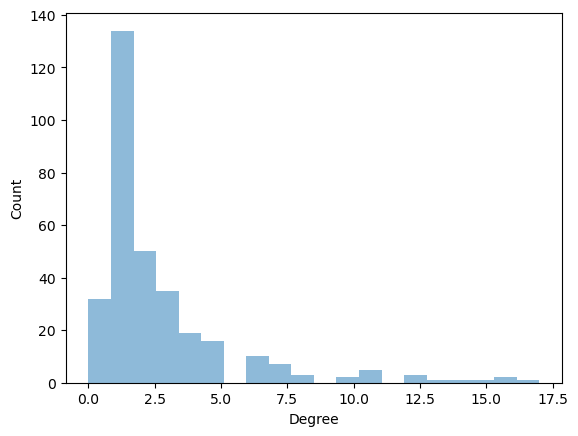

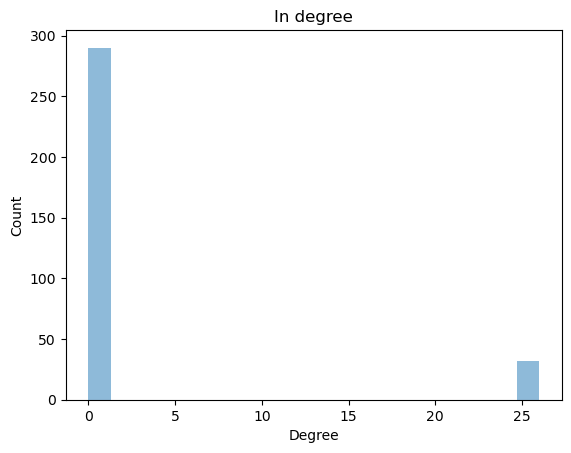

In [21]:
network_in_degrees = [G.in_degree(n) for n in G.nodes()]
network_out_degrees = [G.out_degree(n) for n in G.nodes()]

plt.hist(network_out_degrees, bins=20, alpha=0.5)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

plt.hist(network_in_degrees, bins=20, alpha=0.5)
plt.title("In degree")
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()


Agian, the in degree one is not that special. It is more interesting to look at the out degree, here we can see that most clubs have atleast 1 link.  

As we learned from above network there are teams that are represented by only one nationality. We thought it would be fun to see what team is represented by the most nationalities. 

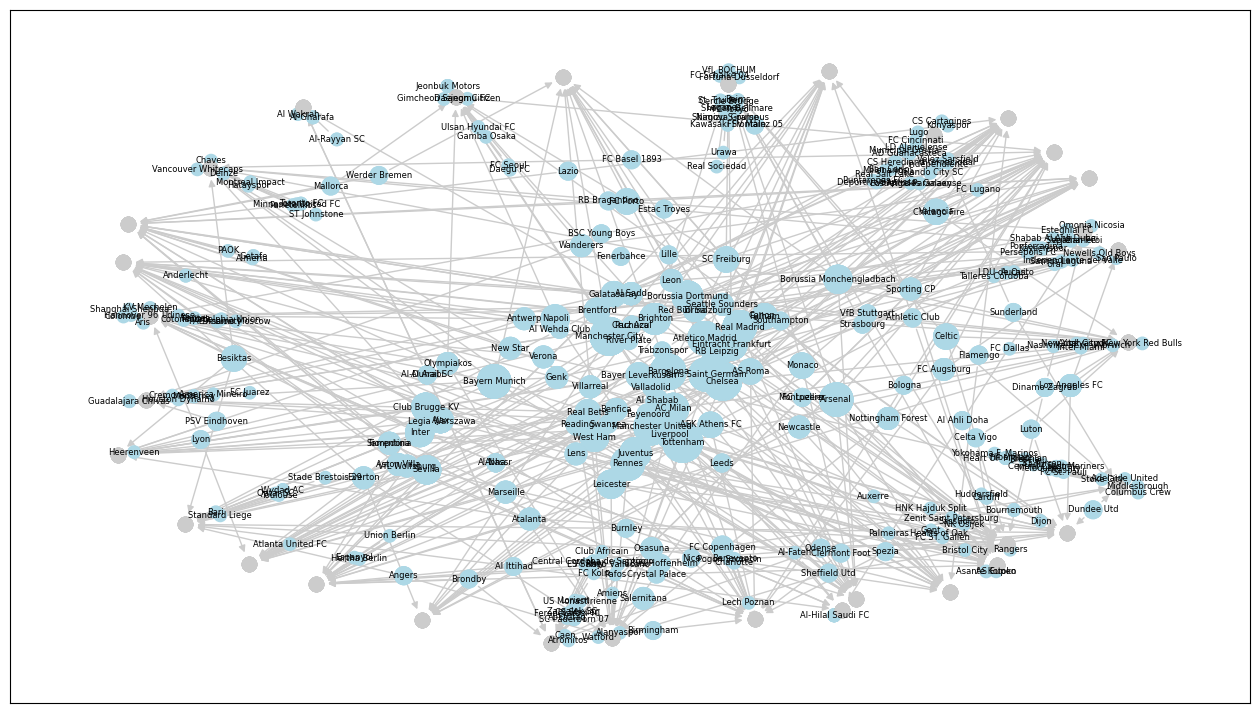

In [22]:
G1 = nx.from_pandas_edgelist(df1, source = 'Club', target = 'Country', create_using=nx.DiGraph)

layout = nx.spring_layout(G1,iterations=50)


plt.figure(figsize = (16,9))

club_size = [G1.degree(club) * 80 for club in club] # size
nx.draw_networkx_nodes(G1, 
                       layout, 
                       nodelist=club, 
                       node_size=club_size, 
                       node_color='lightblue')

# Draw 
nx.draw_networkx_nodes(G1, layout, nodelist=df1['Country'], node_color='#cccccc', node_size=100)

nx.draw_networkx_edges(G1, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(club, club)) # labes of the clubs
nx.draw_networkx_labels(G1, layout, labels=node_labels, font_size=6 )

plt.show()

We can see that AL-Hilal and Al-Sadd is gone now and instead we suddenly have clubs like Manchester united, Frankfurt and Sevilia in center. 

In [23]:
#Lets see who is in top 10
out_degree = G1.out_degree() 
sorted_out_degree = sorted(out_degree, key=lambda x: x[1], reverse=True)
print(sorted_out_degree[:10])

[('Tottenham', 10), ('Manchester City', 9), ('Chelsea', 9), ('Barcelona', 8), ('Manchester United', 8), ('Bayern Munich', 7), ('Atletico Madrid', 7), ('Real Madrid', 7), ('Paris Saint Germain', 7), ('Rennes', 7)]


Wow Tottenham is represented by the most nationalities! 

In [24]:
#Some basic stats

print(nx.info(G1))
print("In-degrees",pd.Series([x[1] for x in list(G1.in_degree)]).describe())
print("Out-degrees:",pd.Series([x[1] for x in list(G1.out_degree)]).describe())

DiGraph with 322 nodes and 585 edges
In-degrees count    322.000000
mean       1.816770
std        5.686567
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       26.000000
dtype: float64
Out-degrees: count    322.00000
mean       1.81677
std        1.69679
min        0.00000
25%        1.00000
50%        1.00000
75%        2.00000
max       10.00000
dtype: float64


C:\Users\Bruger\AppData\Local\Temp\ipykernel_16576\3433420326.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G1))


## Downloadding wikilinks

Now we want all the wiki links

In [25]:
for i in range(len(df1)):

    
 if i == 772: # skip cho-yu-min. For some reason we have a issue with him.
    continue
 else:
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = "titles=" + df1['WikiLink'][i]
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    #print(query)
    wikiresponse = requests.get(query)
    wikidata = wikiresponse.text
    wikitext = wikidata
    #wikitext = wikidata.decode('utf-8')

    #save the wikitext in a file

    with open(df1['WikiLink'][i]+'_player_'+df1['Country'][i]+'.txt', 'w') as f:
        f.write(wikitext)


In [26]:
def parse_links_from_file(file):
    links = set()
    for link in re.findall('\[\[([^\]]*)\]\]', file):
        if '|' in link:
            link = link.split('|')[0]
        links.add(link)
    return [link.lower() for link in links]


def parse_node(node):
    # remove _player_ and everything after it in the filename
    return node.split("_player")[0].replace("_", " ").lower()


G1 = nx.DiGraph()
        
for i in os.listdir(): # getting them from the dictory that we are in.
    if i.endswith(".txt"):
        with open(i, 'r',encoding = 'utf-8') as f:
            file = f.read()
            G1.add_node(parse_node(i), file=i, words = len(re.findall(r'\w+', file)))
         
        
        
        
#add edges to the network
edges = {}

for i in G1.nodes(data=True):
    with open(i[1]['file'], 'r',encoding = 'utf-8') as f:
        file = f.read()
        links = parse_links_from_file(file)
        edges[i[0]] = links

for name, edges in edges.items():
    for edge in edges:
        if edge in list(G1.nodes):
            G1.add_edge(*(name, edge))


In [27]:
#Info
print(nx.info(G1))

DiGraph with 830 nodes and 815 edges


C:\Users\Bruger\AppData\Local\Temp\ipykernel_16576\150455596.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G1))


In [151]:
#Lets see how many nodes really have a link
G2 = max(nx.weakly_connected_components(G1), key=len)

G2 = G1.subgraph(G2)

In [152]:
print(nx.info(G2))

DiGraph with 366 nodes and 785 edges


C:\Users\Bruger\AppData\Local\Temp\ipykernel_16576\265060720.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G2))


Over 400 nodes are not linking to other players. Wonder why.

In [153]:
# basic stats
print(nx.info(G2))
print("In-degrees",pd.Series([x[1] for x in list(G2.in_degree)]).describe())
print("Out-degrees:",pd.Series([x[1] for x in list(G2.out_degree)]).describe())

DiGraph with 366 nodes and 785 edges
In-degrees count    366.000000
mean       2.144809
std        4.559297
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       52.000000
dtype: float64
Out-degrees: count    366.000000
mean       2.144809
std        2.242384
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       12.000000
dtype: float64


C:\Users\Bruger\AppData\Local\Temp\ipykernel_16576\2970335006.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G2))


In [154]:
#creating a labeling function.
labeling={}

for i in G2.nodes:
    if G2.degree()[i] > 20: # we only want those with above 20 links.
        labeling[i] = i

100%|██████████| 100/100 [00:01<00:00, 85.34it/s]


BarnesHut Approximation  took  0.18  seconds
Repulsion forces  took  0.94  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


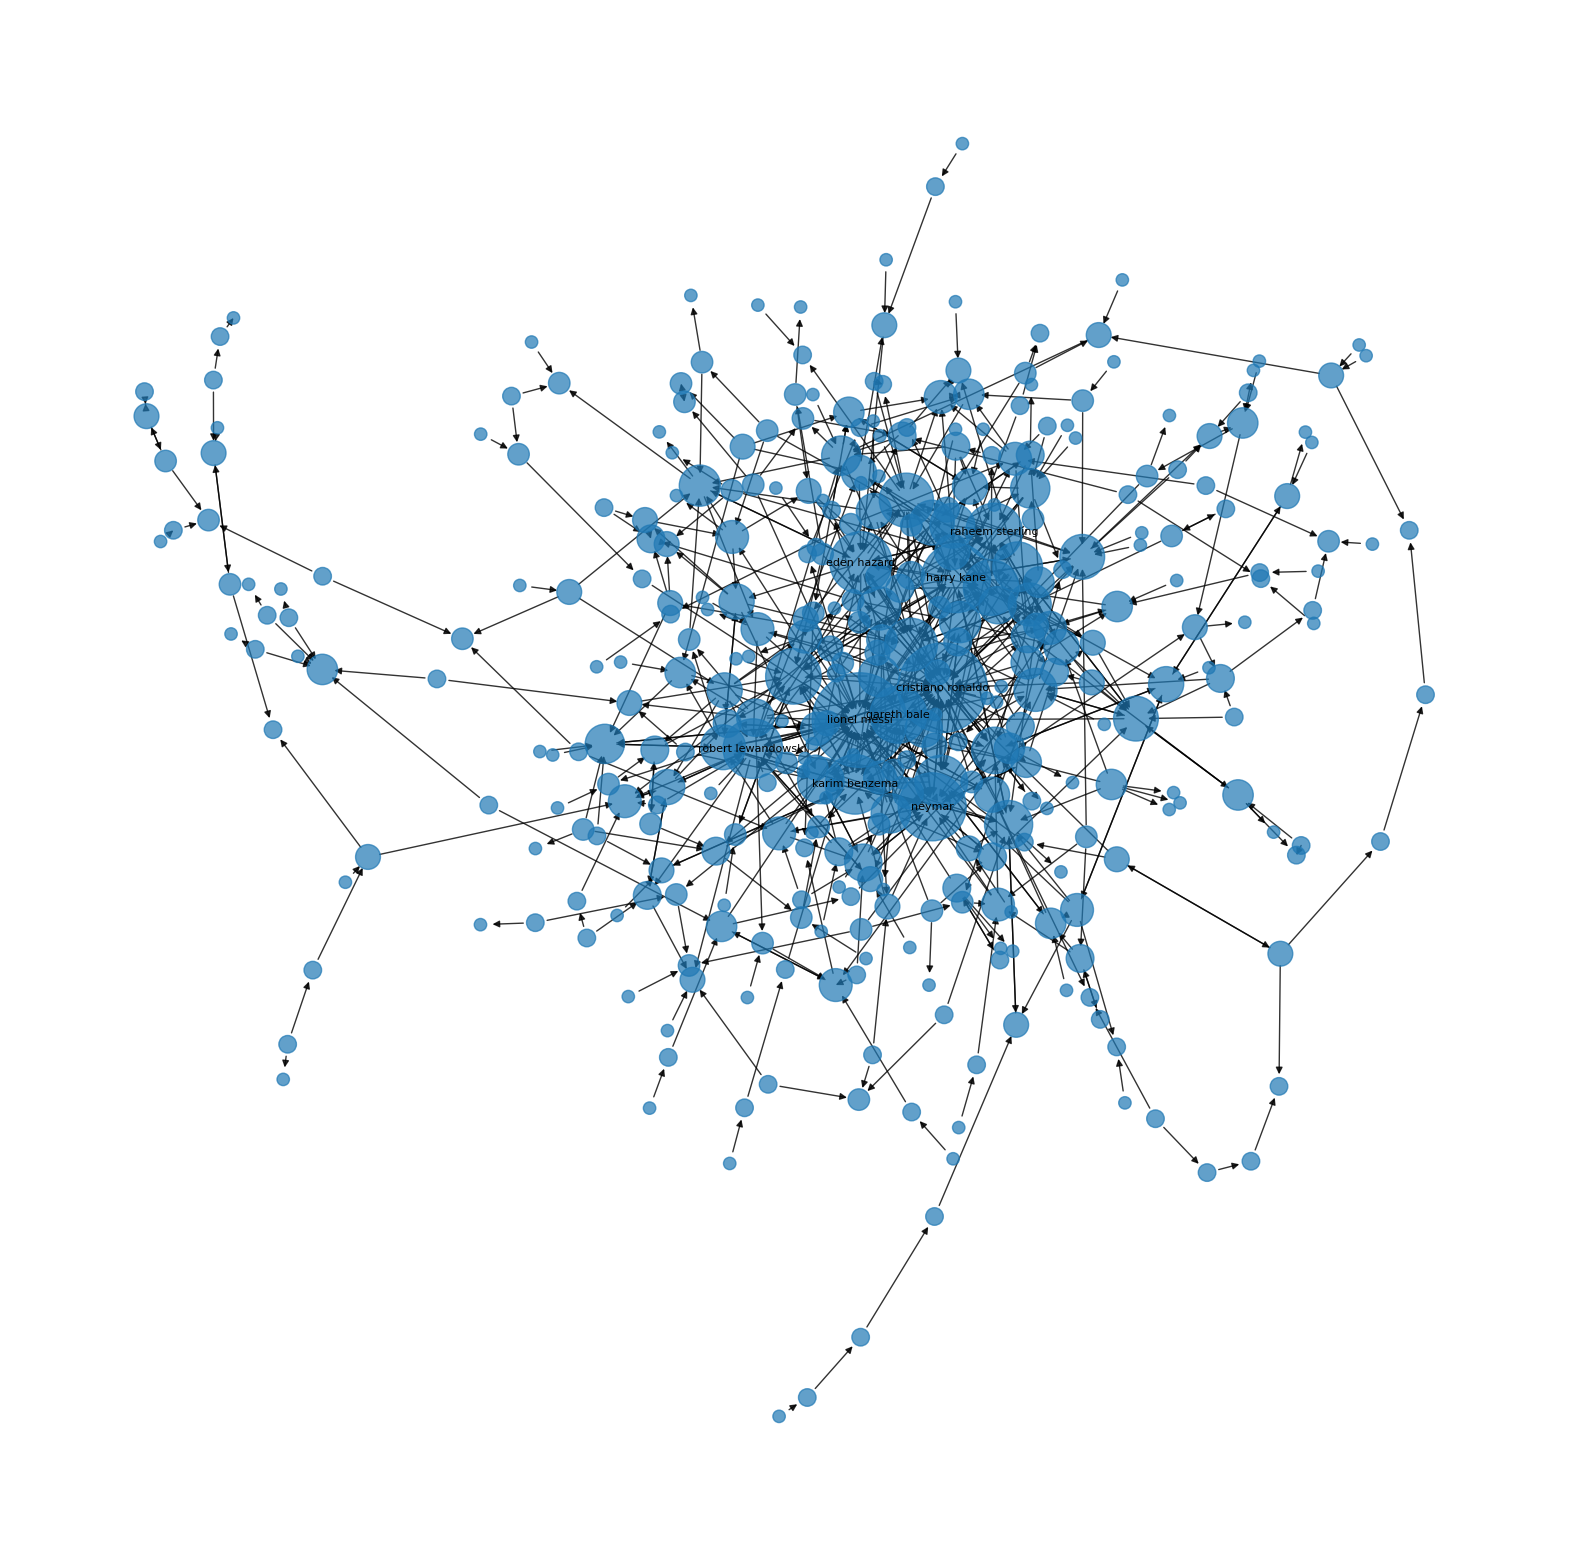

In [159]:
#Using fa
forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.5,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=True)

node_size = [G2.degree(i) * 80 for i in G2.nodes()] #size
positions = forceatlas2.forceatlas2_networkx_layout(G2.to_undirected() , pos=None, iterations=100)

plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(G2, positions, node_size = node_size) #, alpha=0.5) 
nx.draw_networkx_edges(G2, positions, alpha = 0.8)
nx.draw_networkx_labels(G2, positions, labels = labeling, font_size = 8)
plt.axis('off')
plt.show()


These are the top ten most connected players. No suprise with the first 3. However, we thought players like Mbappe and Vinicius would be in top ten. But the reason for their absence is probably that they are young and do not have as much history yet.  

In [156]:
#Creating some functions for the networks. But we are making it a competition. 

def Color_List(champion, first_runner_up, second_runner_up):
    colorList=[]
    for node in G2.nodes:
        if node == champion:
            colorList.append("#ffd700") # gold
        elif node == first_runner_up:
            colorList.append("#aaa9ad") # silver
        elif node == second_runner_up:
            colorList.append("#cd7f32") # bronze
        else:
            colorList.append("#4495b3") # blue
    return colorList


def getLabeling(sortedList, topN): # labeling
    labeling={}
    for node in G2.nodes:
        if node in list(map(lambda x : x[0], sortedList[:topN])):
            labeling[node] = node
    return labeling


def plot(sizes,colors, labeling, adjustFactor): # adjustFactor to control node size
    plt.figure(figsize=(15,10))
    nx.draw_networkx_edges(G2, positions, width = 0.1, alpha = 0.8, arrows=False)
    nx.draw_networkx_nodes(G2, positions,alpha= 0.7, node_color=colors,
                           node_size=[size * adjustFactor for size in sizes])
    nx.draw_networkx_labels(G2, positions, labels=labeling, font_size=8)
    plt.show()
    return  


In [157]:
sorting=sorted(list(G2.in_degree()), key=lambda x : x[1], reverse=True) # sort list by the one with the most links
top3=sorting[:3]
top3


[('lionel messi', 52), ('cristiano ronaldo', 44), ('neymar', 20)]

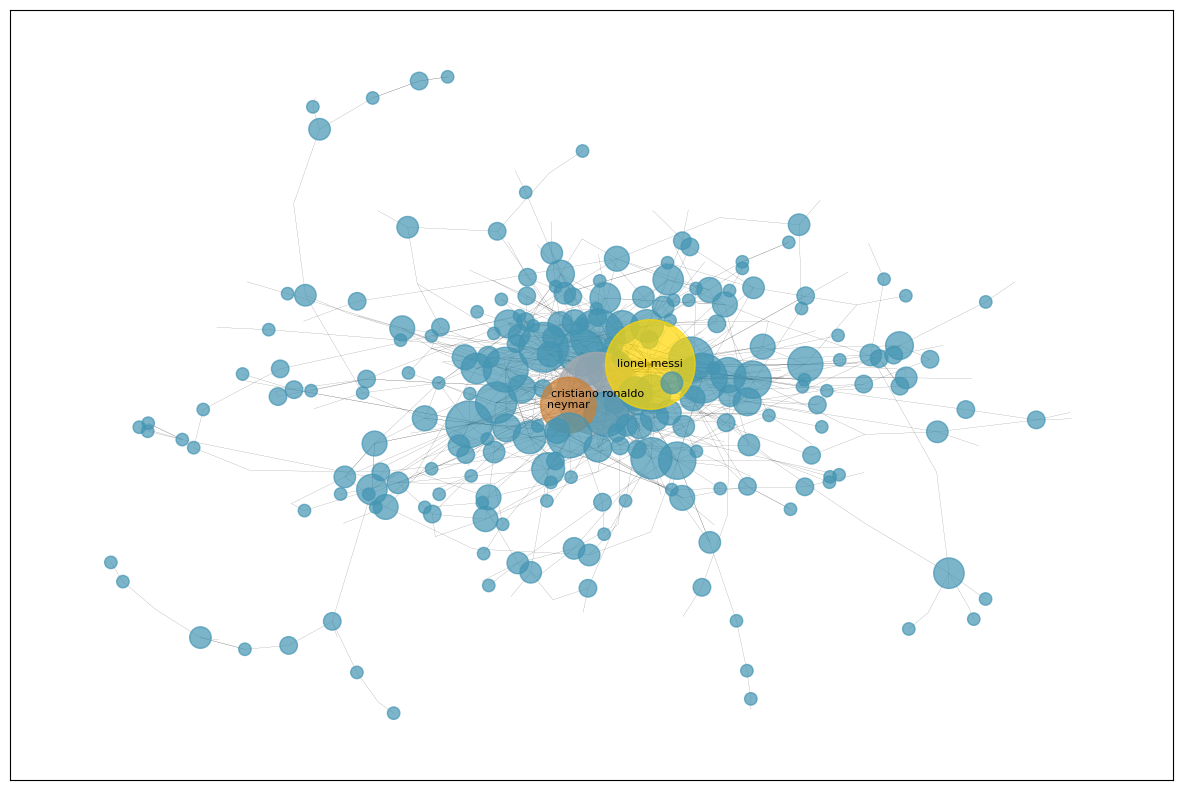

In [158]:

plot([G2.in_degree(i) for i in G2.nodes],
     Color_List('lionel messi','cristiano ronaldo','neymar'),getLabeling(sorting,3),80 )

In [39]:

sorting=sorted(list(nx.closeness_centrality(G2).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3


[('lionel messi', 0.3016307893020222),
 ('cristiano ronaldo', 0.30029020801623546),
 ('neymar', 0.25690226921541054)]

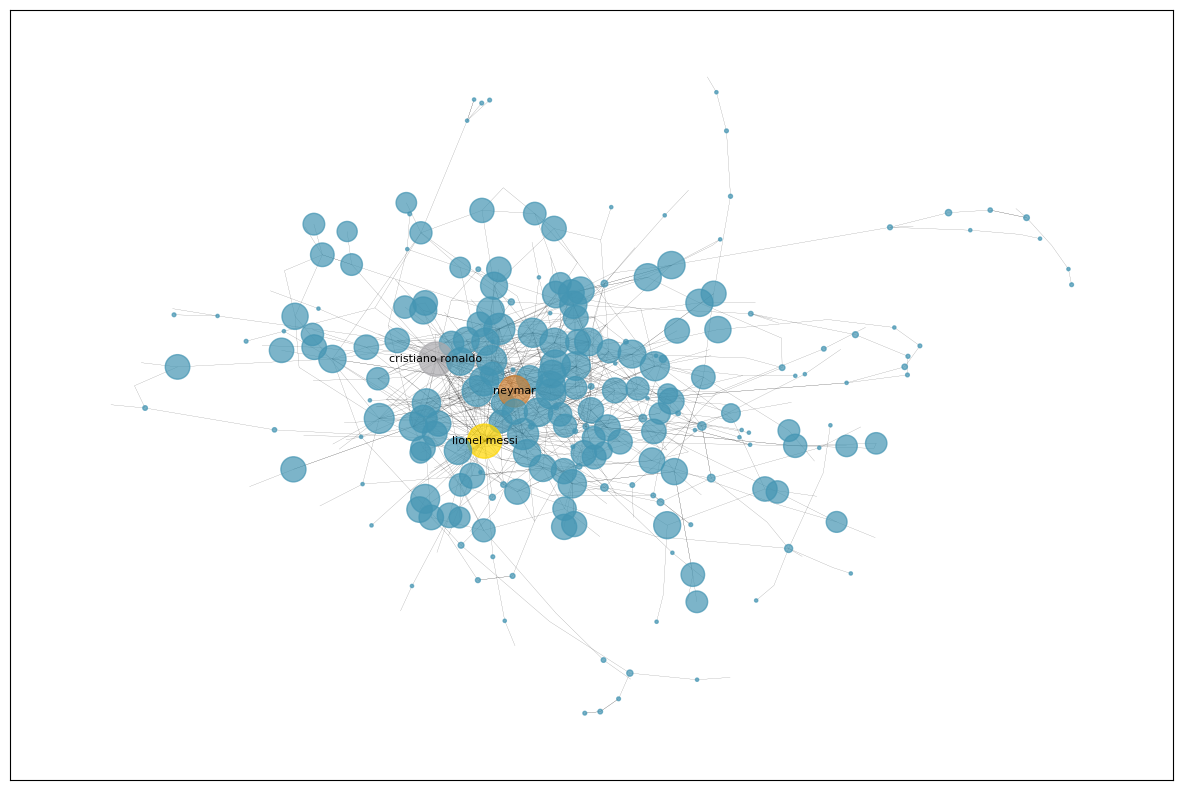

In [40]:
plot(list(nx.closeness_centrality(G2).values()),
     Color_List('lionel messi','cristiano ronaldo','neymar'),
     getLabeling(sorting, 3), 2000)

## Community 

Lets see what communities the different players belong to. We have an idea that it will be based on leagues, so how many are in the same leauge. 

In [41]:
#creating the nodes, using our first dataframe
G = nx.Graph()
G.add_nodes_from(df1['Player'])
G.add_edges_from([(df1['Player'][i], df1['Country'][i]) for i in range(len(df1))])
G.add_edges_from([(df1['Player'][i], df1['Club'][i]) for i in range(len(df1))])
G.add_edges_from([(df1['Player'][i], df1['Leauge_country'][i]) for i in range(len(df1))])

partition = community_louvain.best_partition(G)

In [42]:
# the top leagues 
sorting=sorted(list(G.degree()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('England', 156), ('Spain', 96), ('Germany', 88)]

Most players are in the english league. 

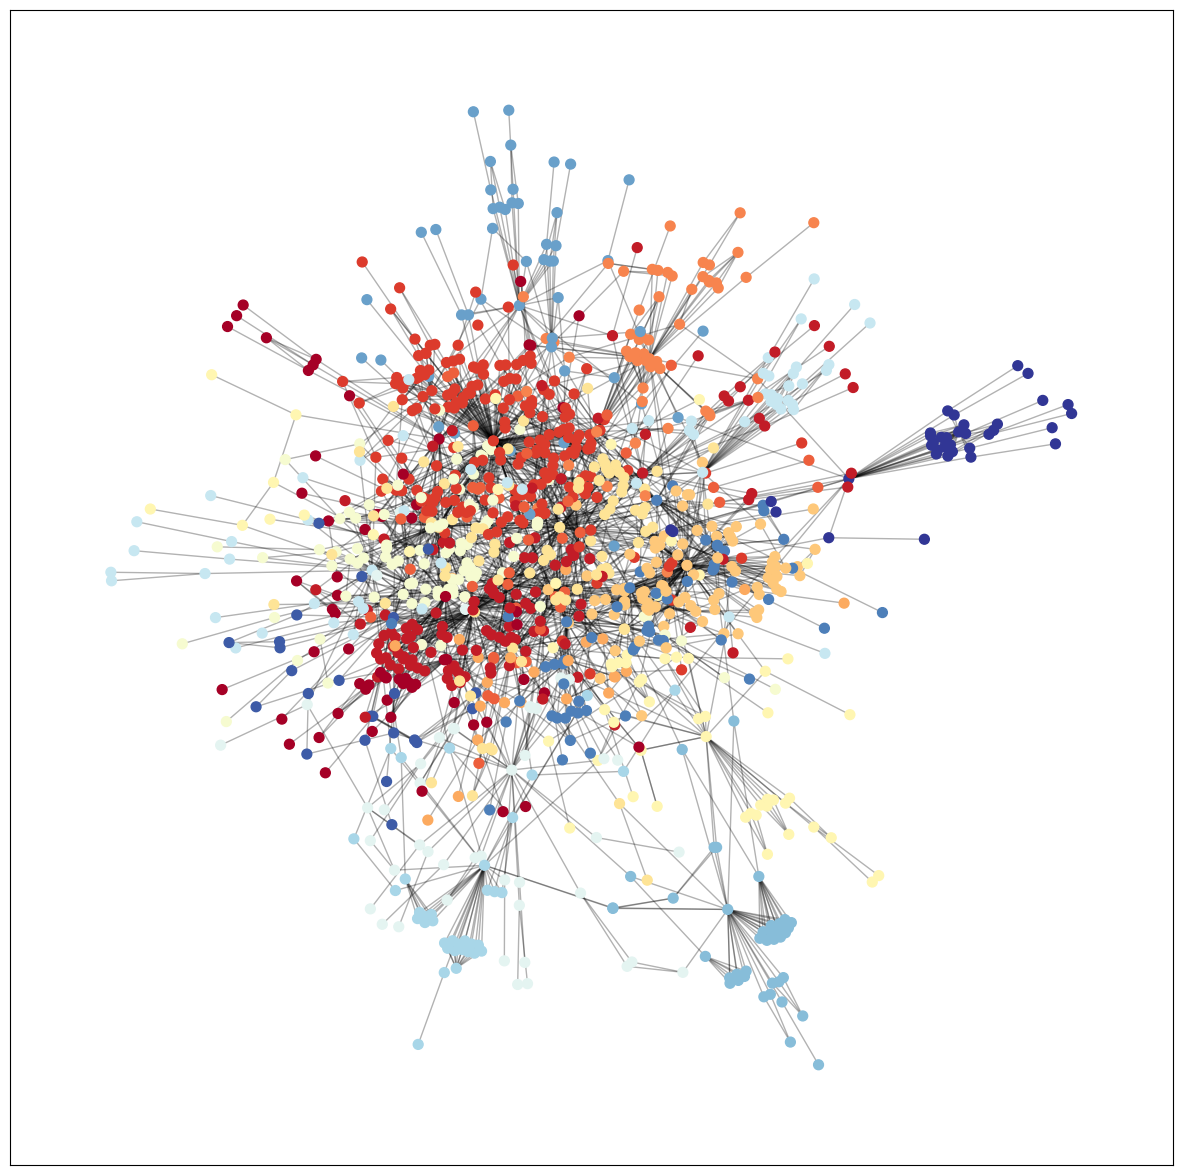

In [43]:
#Plotting the network

pos = nx.spring_layout(G)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.3, label =getLabeling(sorting, 3))
#nx.draw_networkx_labels(G, pos,font_size=5)

plt.show()

We added labels to the graph at first just to see what exactly we are looking at. But had to remove them afterwards because it just became to messy. What we see in central are the big leagues, commonly refered to as the top 5. That is England, Germany, Spain, France and Italy. 

In [44]:
#How many communities do we have?

print("This is my minimum",min(partition.values()))
print("This is my maximum",max(partition.values()))

This is my minimum 0
This is my maximum 17


20 communities, not too bad. 

100%|██████████| 500/500 [00:10<00:00, 45.82it/s]


BarnesHut Approximation  took  2.92  seconds
Repulsion forces  took  7.36  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.26  seconds


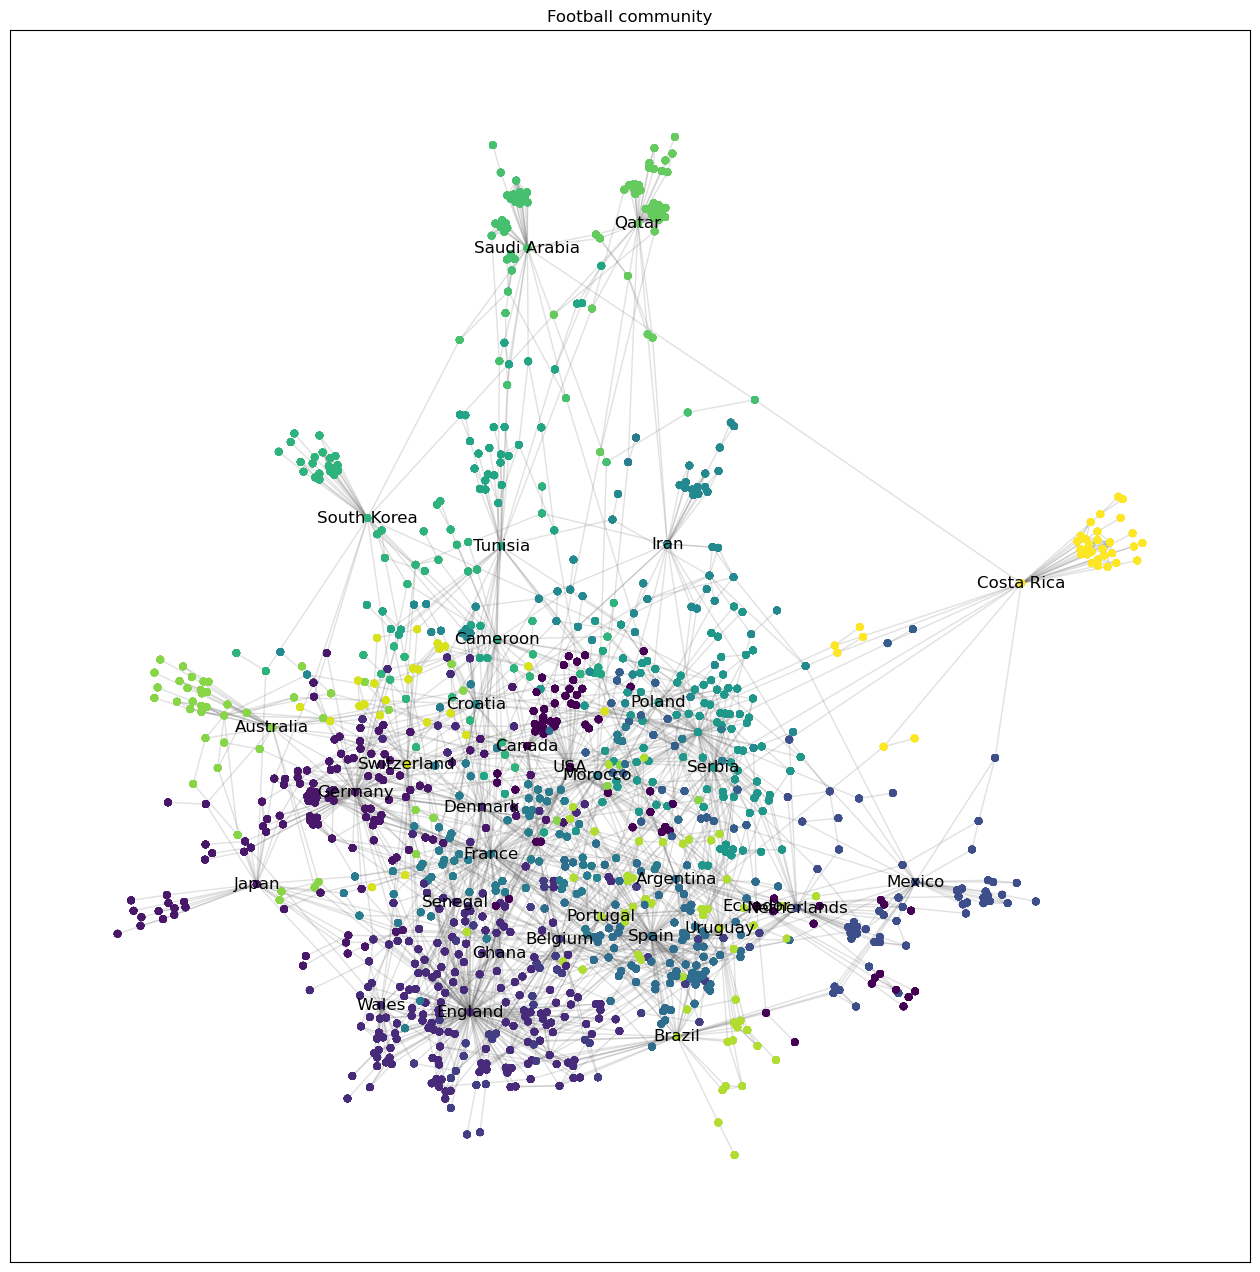

In [165]:
import matplotlib.cm as cm


plt.figure(figsize=(16,16))
pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=500)
count = 0.
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=20,
                     cmap=cmap, node_color=list(partition.values()))


communities=nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color="dimgray")
node_labels = {}
node_labels = {}
for i, node in enumerate(df1['Country']):
    node_labels[node] = df1['Country'][i]

nx.draw_networkx_labels(G, pos, labels=node_labels)

plt.title("Football community")
plt.savefig("Football_community")
plt.show()

Now with the added labels. It is clearer to see the big communities now.

## Sentiment part

For creating the sentiment analysis we had to find a bunch of articles that decribes each country participating in the world cup. However as these are interactive articles we had to do it a bit differntly. Furthermore, we also found that guardian had their articles locked so we had to fetch 32 keys for each of the countries and used them below. 

In [47]:
all_ids = {
        "equador": "1xc85Qk0pzoeR5jpeLU1dP9HddFqdjVty-Kv4tjC8XPY",
        "netherlands": "1N1wf1oUw8OwLj1kXbixifY0xD1tW9RW17r8l3veG86g",
        "qatar": "1lMvk1bSJ24SPd8I5eMjMXBVr6OO-bKkw_J0NjPZt2nA",
        "seneegal": "1V6SD0MqUVs3J0EhHaPHiNRZkyDEqGnGVWJnex-QW_hE",
        "england": "15retV7YllqsTR_MyW8nOgUf9fVm3TroJRVtkGHFBqrw",
        "iran": "17HY03KVeq0WQCNl0SnehJa18FK2b7QPNzpvfUpTNbpU",
        "united-states": "1147Na6XK5N-GvstVHDtt4eGhJVuw2HSvGUtqEjjhPbs",
        "wales": "1pbgL-f7fyh8iI0OGibqeR6W6xYO2LtA4xPjIHEkEpeo",
        "argentina": "1JABE3VYTo1F0t9WxcGsDjC6a2idF8d_btbtIIgwV1FU",
        "mexico": "1cmn2MO_NnsvhkYtbDqQ-WTWu51fYzxAChHujEKpjI24",
        "polen": "1cWW9DraYiyf7A5ueITLAQIcXgn8WjI7vK3TolIvwfQQ",
        "australien": "1gdXa2jAl_TDsNUbc3KcXmJmFN5jY3YxUcpXS9XrgjJI",
        "denmark": "1mz3egryRXHuIEppc7WNTHAg89I53_zkCIQ2oKqn4zWA",
        "france": "1m-rwGKnlDbEItNFKcf6daNG63ib5verOatxm6XK3a0A",
        "tunesien": "1zxHZ7SPEUnPqb9xbV4NSfSTCQxUnfDq9gSF9nO-0d7w",
        "costa-rica": "1obbrY1o71q5hcWGBCicg9xSGUv5lCfT-c14DqLxsiYU",
        "germany": "1cdWojP9yF0BFQxN47d4PfokRP7K8n46fUhZ4JYh3FAA",
        "japan": "1yjeG9H28FZJag88-CRsbjuQxYHPR1gpm-OsfwFZdhsw",
        "spain": "1Xv6kMCgho1Yr9a3f4JZoDWcn4MGi3jNtwq_LSwhmPoE",
        "belgium": "1tHvzmC0Pz2z_CT_F91Jh4dSnGXo_VE8FEyKkgTXkti8",
        "canada": "142exB4McAfVXgX26jhpErMr1K0yJe-iZioYa1Wro0So",
        "croatia": "1bLItGv7x-JqN2-L2RWqags1mrIHI0N-qiN8mx0nS24E",
        "morocco": "1hANEXs8eTKHtMSxpjDLygD6F-UEwWXoEtLG6oU6ollo",
        "brazil": "173Xiho8VrXMDbOMVapH33L1w044kA1bbUBnd8oltcys",
        "cameroon": "1L88yR6tadKyhz_4jeZu5-myBHSLT-TDqu6odB4TNrFk",
        "serbia": "13O5oZpcZnhD7BKWy-JlE3oBKqBV0N2h46_lIYEDjcbU",
        "switzerland": "1b1q3vgoZjYSLFZtBZg2N0PnJJGn2E7_C0HvaFugJYDg",
        "ghana": "1WtYFKbyuOfwn2mfCYFZSr7-f8UKuv3ooDFRWDcbd1P4",
        "portugal": "1Qys1bSclmV04XYCAbTqPJuxQ13HeluyxhjIVp3g8Izo",
        "south korea": "1kEvxOJL5iv9cEQPGAZJ4B7NqyYLd1yT1l6_aI2ItX5o",
        "uruguay": "1-SNLlwhppsF9IYdfUDnWpBNGywGl2LEKgAnS1X6pZSc",
}
 
def get_team_info(id):
    headers = {
        'authority': 'interactive.guim.co.uk',
        'origin': 'https://www.theguardian.com',
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36',
    }
    
    response = requests.get(f'https://interactive.guim.co.uk/docsdata/{id}.json', headers=headers)
    data1 = response.json()
    return data1
 
def get_team_summaries():
    response = requests.get('https://www.theguardian.com/football/ng-interactive/2022/nov/16/world-cup-2022-player-profiles-qatar-match-ratings')
    test = response.content
    soup = BeautifulSoup(test, 'html.parser')
    data2 = {}
    data2['gv-team-info-bio'] = soup.find_all('p', class_='gv-team-info-bio')
    data2['gv-team-info-strengths'] = soup.find_all('p', class_='gv-team-info-strengths')
    data2['gv-team-info-weaknesses'] = soup.find_all('p', class_='gv-team-info-weaknesses')
    data2['gv-team-info-coach'] = soup.find_all('div', class_='gv-team-info-coach')
    return data2
 
team_summaries = get_team_summaries()

# there are four interactive links on the webiste - bio,strengths,weakness, coach. We need the information for each link

for i, name in enumerate(all_ids.keys()):
    team_summary = [get_team_info(all_ids[name])]
    team_summary.append(team_summaries['gv-team-info-bio'][i].text) 
    team_summary.append(team_summaries['gv-team-info-strengths'][i].text)
    team_summary.append(team_summaries['gv-team-info-weaknesses'][i].text)
    team_summary.append(team_summaries['gv-team-info-coach'][i].text)
    # save a text file with teaminfo and team_summary called name.txt
    with open(f'{name}_guardian.txt', 'w', encoding='utf-8') as f:
        f.write(str(team_summary))

In [48]:
# using the wordlist form LaBMIT
senti_set = pd.read_csv("Data_Set_S1.txt", sep="\t")

Removing the neutral words to hopefully get a better understanding of the texts and how the newspapers feel towards certian teams

In [49]:
#senti_set = senti_set.drop(columns =['happiness_rank','twitter_rank','twitter_rank','google_rank','nyt_rank','lyrics_rank'])

#removing delta 2 around average 5.
senti_set = senti_set.drop(senti_set[(senti_set['happiness_average'] <= 6) & (senti_set['happiness_average'] >= 4)].index)
senti_set.reset_index(drop = True, inplace=True)

word_happiness = dict(zip(senti_set.word.tolist(), senti_set.happiness_average.tolist())) # creating a dict that matches word with happiness

Writing functions to clean the texts for unnecessary words 

In [50]:
stop_words = nltk.corpus.stopwords.words('english') # removing stopwords
tokenizer = RegexpTokenizer(r'\w+')

#Creating some text cleaning functions

def prep_text(x): # preparing the data, removing what is not needed 
    corp = str(x).lower() #lower case
    corp = re.sub('[^a-zA-Z]+',' ', corp).strip() # removing numerical values
    tokens = word_tokenize(corp)
    words = [t for t in tokens if t not in stop_words] # removing stopwords

    return words


def sentiment(tokens): # here we are couniting the tokens 
    total=0
    count=0
    for t in tokens:
        # if Token found in the text
        if t in word_happiness:
            total += word_happiness[t]
            count +=1
    # If tokens are not in the list then it is set to 0(being ignored) 
    if count == 0:
        return 0
    return total/count

### The guardian article

In [51]:
senti_score_guardian = [] # senti score for the guardian article 

for i,country in enumerate(all_ids.keys()):
    for i in os.listdir():
        if i.startswith(f'{country}_guardian.txt'):
            with open(i,'r', encoding = 'utf-8') as f:
                senti_score_guardian.append(sentiment(prep_text(f.read())))
                #print(f'The sentiment score for {all_ids[i]} is {senti_score_guardian[country]}')

In [52]:
for i,country in enumerate(all_ids.keys()):
    print(f'{country}: {senti_score_guardian[i]}')

equador: 6.502355507088343
netherlands: 6.28535469107551
qatar: 6.487093333333327
seneegal: 6.388806451612912
england: 6.457486136783741
iran: 6.335091164095372
united-states: 6.531232394366195
wales: 6.419323915237129
argentina: 6.325565843621401
mexico: 6.309128686327077
polen: 6.445859788359787
australien: 6.346546583850932
denmark: 6.358838862559242
france: 6.256355140186915
tunesien: 6.33141534391534
costa-rica: 6.395147219193024
germany: 6.416725663716815
japan: 6.495985611510794
spain: 6.354600938967134
belgium: 6.396678529062867
canada: 6.49341115434501
croatia: 6.376732429099878
morocco: 6.3199999999999985
brazil: 6.376450999048536
cameroon: 6.418419889502762
serbia: 6.349052890528905
switzerland: 6.341203407880734
ghana: 6.39923076923077
portugal: 6.440070754716987
south korea: 6.4564766248574745
uruguay: 6.4186159600997525


Even though we removed all the neutral words, it stills seems that the articles are equal in the sense of sentiment.We had maybe thought that it would be bigger the differnece.

In [53]:

# happiest

positive_countries = sorted(zip(all_ids.keys(),senti_score_guardian), key = lambda x: x[1], reverse = True)[:10]

print('The guardians top 10 favorit squads')
for i in positive_countries:
    print(i[0])
    
    
# saddest

negativ_countries = sorted(zip(all_ids.keys(),senti_score_guardian), key = lambda x: x[1])[:10]

print('The guardians top 10 least favorit squads')
for i in negativ_countries:
    print(i[0])

The guardians top 10 favorit squads
united-states
equador
japan
canada
qatar
england
south korea
polen
portugal
wales
The guardians top 10 least favorit squads
france
netherlands
mexico
morocco
argentina
tunesien
iran
switzerland
australien
serbia


In [54]:
def term_f(token_list):
    
    tf={}
    
    for word in token_list:
        if word in tf:
            tf[word] += 1
        else:
            tf[word] = 1
            
    for key in tf.keys():
        tf[key] = tf[key]/len(token_list)
    
    return tf



# Fifa articles 

Downloading the fifa articles 

In [56]:
ids = pd.read_csv("Article_fifa_ids.csv", delimiter=";")

for i in range(len(ids)):



    article_ID = ids['Artikel_id'][i]

    response = requests.get(

    f'https://cxm-api.fifa.com/fifaplusweb/api/sections/article/{article_ID}'

    )

    data = response.json()



    title = response.json()['articleTitle']

    text = response.json()['richtext']['content']



    #save the wikitext in a file



    with open(ids['land'][i] + '_FIFA.txt', 'w', encoding="utf-8") as f:

        f.write(str(text))

In [57]:
senti_score_fifa = []

for i in os.listdir():
    if i.endswith('_FIFA.txt'):
        with open(i,'r', encoding = 'utf-8') as f:
            senti_score_fifa.append(sentiment(prep_text(f.read())))

In [58]:
# happiest

positive_countries = sorted(zip(all_ids.keys(),senti_score_fifa), key = lambda x: x[1], reverse = True)[:10]

print('FIFAs top 10 favorit squads')
for i in positive_countries:
    print(i[0])
    
    
# saddest

negativ_countries = sorted(zip(all_ids.keys(),senti_score_fifa), key = lambda x: x[1])[:10]

print('FIFAs top 10 least favorit squads')
for i in negativ_countries:
    print(i[0])

FIFAs top 10 favorit squads
belgium
netherlands
england
argentina
denmark
wales
brazil
australien
seneegal
tunesien
FIFAs top 10 least favorit squads
iran
united-states
switzerland
croatia
germany
japan
mexico
south korea
france
canada


# Wiki articels 

In [59]:
# create a new dataframe with df1['Country] unique values

df2 = pd.DataFrame(df1['Country'].unique())

# rename the column

df2.columns = ['Country']

# replace " " with "_"

df2['Country'] = df2['Country'].str.replace(' ', '_').str.lower()

for i in range(len(df2)):



    #get the wikitext

    baseurl = "https://en.wikipedia.org/w/api.php?"

    action = "action=query"

    title = "titles=" + df2['Country'][i] + "_national_football_team"

    content = "prop=revisions&rvprop=content"

    dataformat ="format=json"

    

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

    print(query)

    wikiresponse = requests.get(query)

    wikidata = wikiresponse.text

    wikitext = wikidata

    with open(df2['Country'][i] + '_wiki.txt', 'w') as f:

        f.write(wikitext)

https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=ecuador_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=netherlands_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=iran_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=argentina_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=usa_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=wales_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=belgium_national_football_team&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=japan_national_footbal

In [60]:
senti_score_wiki = []

for i in os.listdir():
    if i.endswith('_wiki.txt'):
        with open(i,'r', encoding = 'utf-8') as f:
            senti_score_wiki.append(sentiment(prep_text(f.read())))

In [61]:
# happiest

positive_countries_wiki = sorted(zip(all_ids.keys(),senti_score_wiki), key = lambda x: x[1], reverse = True)[:10]

print('Wikipedias top 10 favorit squads')
for i in positive_countries_wiki:
    print(i[0])
    
    
# saddest

negativ_countries_wiki = sorted(zip(all_ids.keys(),senti_score_wiki), key = lambda x: x[1])[:10]

print('Wikipedias top 10 least favorit squads')
for i in negativ_countries_wiki:
    print(i[0])

Wikipedias top 10 favorit squads
south korea
equador
mexico
france
japan
portugal
costa-rica
germany
uruguay
seneegal
Wikipedias top 10 least favorit squads
serbia
canada
spain
qatar
ghana
denmark
tunesien
wales
belgium
united-states


In [62]:
# make df2 Country to lower case

df2['Country'] = df2['Country'].str.lower()

Country
0      ecuador
1  netherlands
2         iran
3    argentina
4          usa

In [63]:
# loop through all files in os.listdir() and if the file contain the country name then add it to a new txt file with the country name and the word "combined" 

for i in os.listdir():
    for j in df2['Country']:
        if j in i:
            with open(j + '_combined.txt', 'a', encoding = 'utf-8') as f:
                with open(i, 'r', encoding = 'utf-8') as f2:
                    f.write(f2.read())

                    

In [64]:
senti_score_combined = []

for i in os.listdir():
    if i.endswith('_combined.txt'):
        with open(i,'r', encoding = 'utf-8') as f:
            senti_score_combined.append(sentiment(prep_text(f.read())))





In [65]:
# happiest

positive_countries_combined = sorted(zip(all_ids.keys(),senti_score_combined), key = lambda x: x[1], reverse = True)[:10]

print('Combined top 10 favorit squads')
for i in positive_countries_combined:
    print(i[0])
    
    
# saddest

negativ_countries_combined = sorted(zip(all_ids.keys(),senti_score_combined), key = lambda x: x[1])[:10]

print('Combined top 10 least favorit squads')
for i in negativ_countries_combined:
    print(i[0])

Combined top 10 favorit squads
south korea
netherlands
france
equador
iran
mexico
uruguay
japan
costa-rica
portugal
Combined top 10 least favorit squads
serbia
spain
canada
qatar
morocco
united-states
ghana
tunesien
wales
belgium


# Team exploration

In [76]:
# create a network for each country calling them "G"Country""" where league_country is linked and "G1"Country""" where club is the only link linked

for i in df1['Country'].unique():
    globals()['G' + i] = nx.DiGraph()
    globals()['G1' + i] = nx.DiGraph()
    for index, row in df1.iterrows():
        if row['Country'] == i:
            globals()['G' + i].add_node(row['Player'], club=row['Club'], League_country=row['Leauge_country'], caps=row['Caps'])
            globals()['G1' + i].add_node(row['Player'], club=row['Club'], League_country=row['Leauge_country'], caps=row['Caps'])
            
    for player1 in globals()['G' + i].nodes(data=True):
        for player2 in globals()['G' + i].nodes(data=True):
            if player1[1]['club'] == player2[1]['club']:
                if player1[0] != player2[0]:
                    globals()['G' + i].add_edge(player1[0], player2[0])
            if player1[1]['League_country'] == player2[1]['League_country']:
                if player1[0] != player2[0]:
                    globals()['G' + i].add_edge(player1[0], player2[0])
                    
    for player1 in globals()['G1' + i].nodes(data=True):
        for player2 in globals()['G1' + i].nodes(data=True):
            if player1[1]['club'] == player2[1]['club']:
                if player1[0] != player2[0]:
                    globals()['G1' + i].add_edge(player1[0], player2[0])


In [77]:
# loop through the networks and find the network with most edges
for i in df1['Country'].unique():
    print(i)
    print(nx.info(globals()['G' + i]))
    print(nx.info(globals()['G1' + i]))
    print('')

    

Ecuador
DiGraph with 26 nodes and 50 edges
DiGraph with 26 nodes and 14 edges

Netherlands
DiGraph with 26 nodes and 156 edges
DiGraph with 26 nodes and 54 edges

Iran
DiGraph with 25 nodes and 78 edges
DiGraph with 25 nodes and 26 edges

Argentina
DiGraph with 26 nodes and 126 edges
DiGraph with 26 nodes and 20 edges

USA
DiGraph with 26 nodes and 134 edges
DiGraph with 26 nodes and 8 edges

Wales
DiGraph with 26 nodes and 348 edges
DiGraph with 26 nodes and 20 edges

Belgium
DiGraph with 26 nodes and 90 edges
DiGraph with 26 nodes and 18 edges

Japan
DiGraph with 26 nodes and 110 edges
DiGraph with 26 nodes and 4 edges

Spain
DiGraph with 26 nodes and 328 edges
DiGraph with 26 nodes and 72 edges

Ghana
DiGraph with 26 nodes and 78 edges
DiGraph with 26 nodes and 2 edges

Poland
DiGraph with 26 nodes and 106 edges
DiGraph with 26 nodes and 4 edges

Switzerland
DiGraph with 26 nodes and 88 edges
DiGraph with 26 nodes and 8 edges

Mexico
DiGraph with 26 nodes and 170 edges
DiGraph with 

C:\Users\Bruger\AppData\Local\Temp\ipykernel_16576\2184592544.py:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(globals()['G' + i]))
C:\Users\Bruger\AppData\Local\Temp\ipykernel_16576\2184592544.py:5: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(globals()['G1' + i]))


100%|██████████| 100/100 [00:00<00:00, 4774.56it/s]


BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


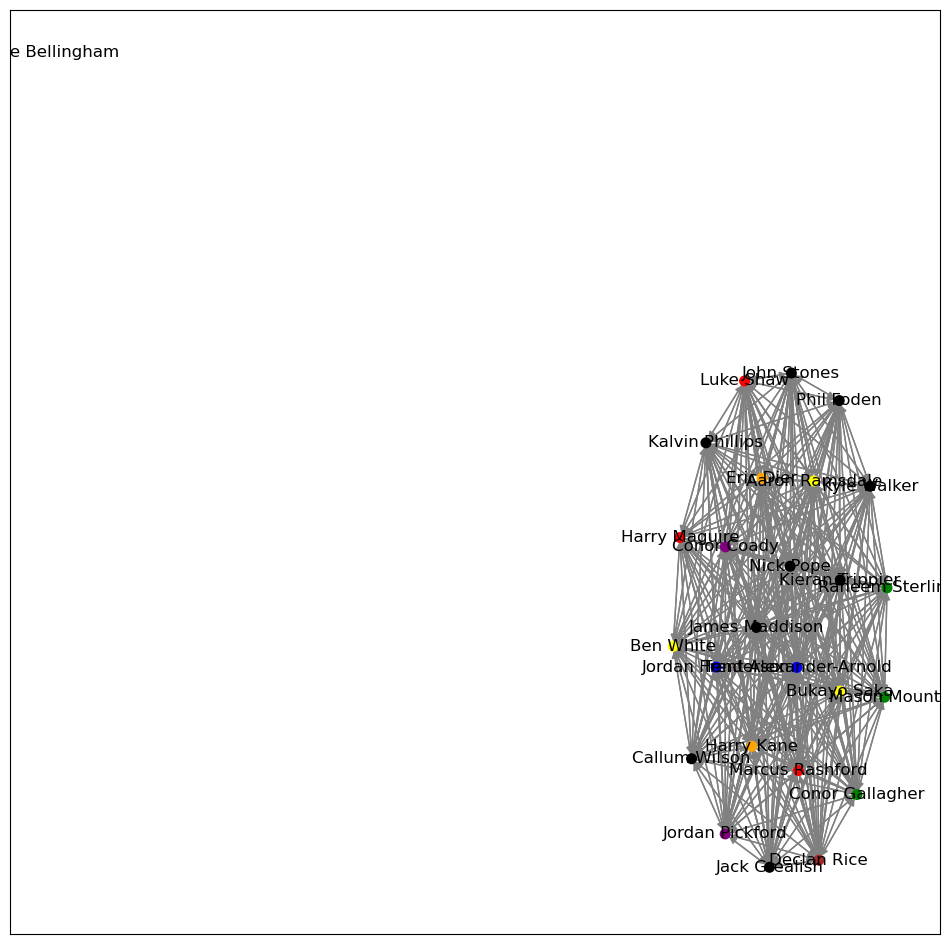

In [84]:
# draw the network for England
colormap = []
for i in GEngland.nodes(data=True):
    if i[1]['club'] == 'Manchester United':
        colormap.append('red')
    elif i[1]['club'] == 'Liverpool':
        colormap.append('blue')
    elif i[1]['club'] == 'Chelsea':
        colormap.append('green')
    elif i[1]['club'] == 'Arsenal':
        colormap.append('yellow')
    elif i[1]['club'] == 'Tottenham':
        colormap.append('orange')
    elif i[1]['club'] == 'Everton':
        colormap.append('purple')
    elif i[1]['club'] == 'Leicester':
        colormap.append('black')
    elif i[1]['club'] == 'West Ham':
        colormap.append('brown')
    elif i[1]['club'] == 'Aston Villa':
        colormap.append('pink')
    elif i[1]['club'] == 'Wolves':
        colormap.append('grey')
    else:
        colormap.append('black')

edge_color = []
for i in GEngland.edges(data=True):
    if i[0] == i[1]:
        edge_color.append('red')
    else:
        edge_color.append('grey')

node_size = [GEngland.degree(i) * 1 for i in GEngland.nodes()]

forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=0.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=1.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(GEngland, pos=None, iterations=100)

plt.figure(figsize=(12,12))
nx.draw_networkx(GEngland, pos=positions, node_size=node_size, node_color=colormap, edge_color=edge_color, with_labels=True)
plt.show()




For further investigation we wanted to see what the networks would look like at a national team level. As this would probably give the best indication of how good a chemistry is on a team if they all played in the same league or the same team. Here for instance we take a look at the english team. We see that they have 25 players playing in the same league and only one, Jude Bellingham, playing in the Bundsliga. Therefore, the english team might have a really good chemistry, right? 

Just to further analysis the english team we wanted to see if they also played on the same teams. 

100%|██████████| 100/100 [00:00<00:00, 5558.83it/s]


BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


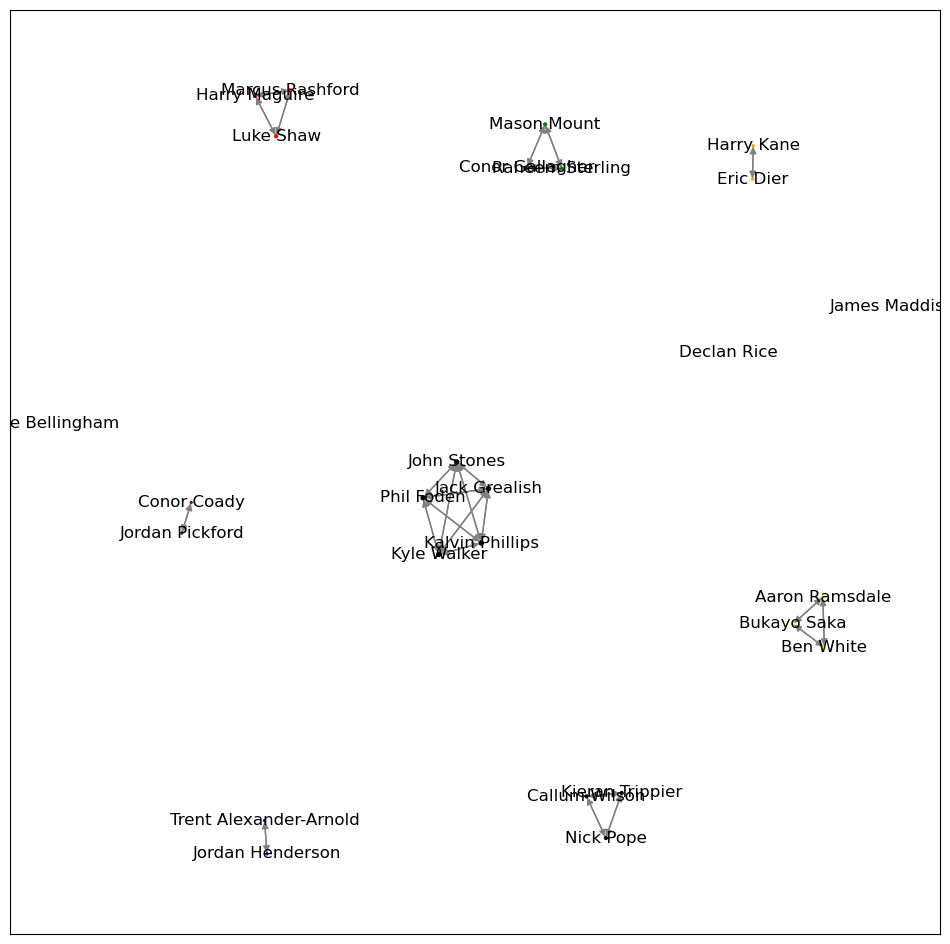

In [86]:
# draw the network for England
colormap = []
for i in G1England.nodes(data=True):
    if i[1]['club'] == 'Manchester United':
        colormap.append('red')
    elif i[1]['club'] == 'Liverpool':
        colormap.append('blue')
    elif i[1]['club'] == 'Chelsea':
        colormap.append('green')
    elif i[1]['club'] == 'Arsenal':
        colormap.append('yellow')
    elif i[1]['club'] == 'Tottenham':
        colormap.append('orange')
    elif i[1]['club'] == 'Everton':
        colormap.append('purple')
    elif i[1]['club'] == 'Leicester':
        colormap.append('black')
    elif i[1]['club'] == 'West Ham':
        colormap.append('brown')
    elif i[1]['club'] == 'Aston Villa':
        colormap.append('pink')
    elif i[1]['club'] == 'Wolves':
        colormap.append('grey')
    else:
        colormap.append('black')

edge_color = []
for i in G1England.edges(data=True):
    if i[0] == i[1]:
        edge_color.append('red')
    else:
        edge_color.append('grey')

node_size = [G1England.degree(i) * 1 for i in G1England.nodes()]

forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=0.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=1.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G1England, pos=None, iterations=100)

plt.figure(figsize=(12,12))
nx.draw_networkx(G1England, pos=positions, node_size=node_size, node_color=colormap, edge_color=edge_color, with_labels=True)
plt.show()


This was not the case. It seems that the english team is split and play for different teams. To make matter worse, there are intense riveraly between the teams that the english players play for, a rivalry they might bring to the national team. This would affect the chemistry negativly. 

We did this iterative process for many of the teams just to analysis them further. 

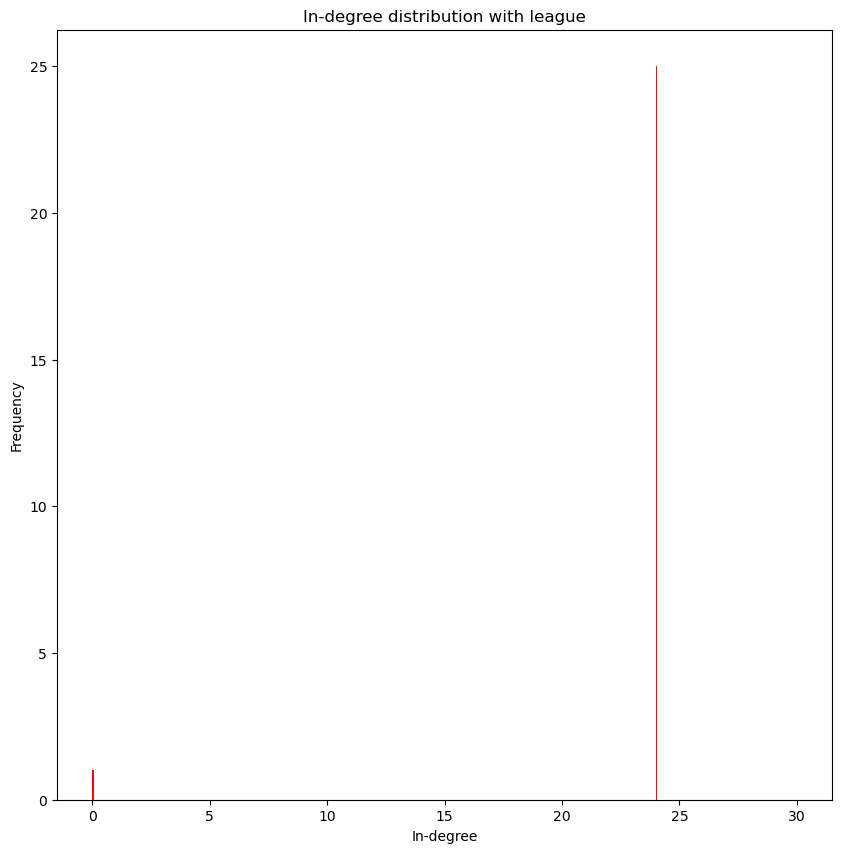

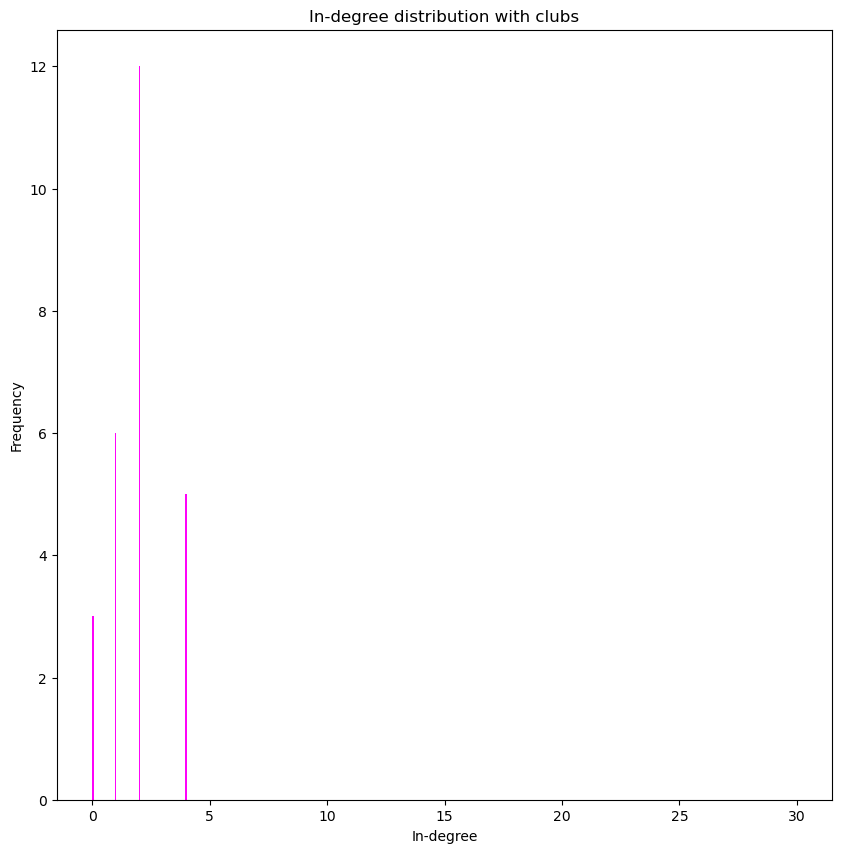

In [95]:
#create in-degree and out-degree distributions for the network

in_degree_with_league = list(dict(GEngland.in_degree()).values())
In_degree_with_clubs = list(dict(G1England.in_degree()).values())

# plot the in-degree distribution

plt.figure(figsize=(10,10))
plt.hist(in_degree_with_league, bins=500, color='#FE0308', range=(0,30))
plt.title("In-degree distribution with league")
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.show()

# plot the out-degree distribution

plt.figure(figsize=(10,10))
plt.hist(In_degree_with_clubs, bins=500, color='#FE03F9', range=(0,30))
plt.title("In-degree distribution with clubs")
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.show()

Degree distribution of the team. 

In [105]:
#Remove cite and ref from text

def remove_cite_ref(text):
  tokens = nltk.word_tokenize(text)
  new_tokens = [token for token in tokens if token != 'cite' and token != 'ref']
  return ' '.join(new_tokens)  
    
    
# prep the text
def new_prep_text(x):  
    lines = remove_cite_ref(x)
    lines = word_tokenize(lines)
    words_text = [w.lower() for w in lines if w.isalpha()]
    tokens = FreqDist(words_text)
    stopwords = nltk.corpus.stopwords.words('english')
    words = [w for w in tokens]
    for w in words: 
        if w in stopwords or not w.isalpha():
            tokens.pop(w)
    return tokens
            
            

In [106]:
#Finding all the articles in our directory
for i in os.listdir():
    if i.endswith("_FIFA.txt") or i.endswith("_guardian.txt"):
        with open('articles_combined.txt', 'a', encoding = 'utf-8') as f:
                with open(i, 'r', encoding = 'utf-8') as f2:
                    f.write(f2.read())


We want to analysis all the articles just to figure what common football terms that have been used before this world cup

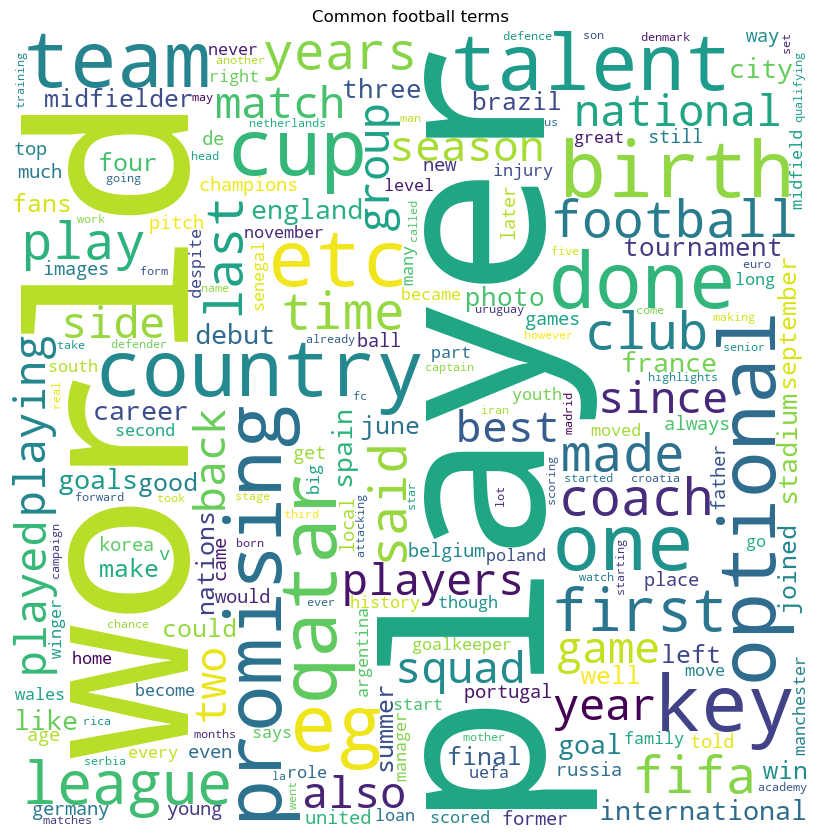

In [160]:
with open('articles_combined.txt','r', encoding = 'utf-8') as f:
         article=f.read()
        
words_text= new_prep_text(article)
        
# Calculate the term frequency
tf = Counter()
for word in words_text:
    tf[word] += 1

# Calculate the inverse document frequency
idf = Counter()
for word in words_text:
    idf[word] += 1

# Calculate the TF-IDF
tfidf = Counter()
for word in words_text:
    tfidf[word] = tf[word] * idf[word]

# Visualize the TF-IDF in a wordcloud
wordcloud = WordCloud(width=800, height=800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(tfidf) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Common football terms")
#plotting 200 words
plt.show()

Looking at the wordcloud we can see a lot of different words have been used before this worldcup. Player, Country and Talent are some of the most common used words in the articles. What is fun is to see words such as key, done and birth. They have probably been mentioned in regards to someone being " a key player" and " birth country". This world cup we have seen a lot of players not representing their birth country or players choosing to represent their birth nation instead of the country they grew up in.    

The following students contribution to the explainer notebook, data gathering notebook and data cleaning notebook:

**Emil Deshasta, s174791:** data gathering, data cleaning, basic stats, network, sentiment 

**Simon Skrøder, s174812:** data gathering & preprocessing, basic stats, data cleaning, network